In [2]:

# Core libraries
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.ticker import PercentFormatter
from typing import Dict, Tuple, List
from scipy import stats

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.utils.class_weight import compute_class_weight
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.utils import check_X_y

try:
    from imblearn.over_sampling import SMOTE
    from imblearn.pipeline import Pipeline as ImbPipeline
    _HAS_IMB = True
except Exception:
    _HAS_IMB = False

#import dataset

from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
cardiotocography = fetch_ucirepo(id=193) 
  
# data (as pandas dataframes) 
X = cardiotocography.data.features 
y = cardiotocography.data.targets 
  
# metadata 
print(cardiotocography.metadata) 
  
# variable information 
print(cardiotocography.variables) 



{'uci_id': 193, 'name': 'Cardiotocography', 'repository_url': 'https://archive.ics.uci.edu/dataset/193/cardiotocography', 'data_url': 'https://archive.ics.uci.edu/static/public/193/data.csv', 'abstract': 'The dataset consists of measurements of fetal heart rate (FHR) and uterine contraction (UC) features on cardiotocograms classified by expert obstetricians.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 2126, 'num_features': 21, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['CLASS', 'NSP'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2000, 'last_updated': 'Fri Mar 15 2024', 'dataset_doi': '10.24432/C51S4N', 'creators': ['D. Campos', 'J. Bernardes'], 'intro_paper': None, 'additional_info': {'summary': '2126 fetal cardiotocograms (CTGs) were automatically processed and the respective diagnostic features measured. The CTGs were also classified

Data Cleaning and Preprocessing

We double verify missing value, drop CLASS feature as it will cause data leakage, encode labels, split trian and test set and use SMOTE for training set to handle imbalance. 

In [3]:
# Data Cleaning and Preprocessing
df = pd.concat(
    [X.reset_index(drop=True), y.reset_index(drop=True)],
    axis=1
)

# Check missing values
missing_total = df.isnull().sum().sum()
print("Number of missing values:", missing_total)

# preprocess function
def preprocess_ctg(
    df: pd.DataFrame,
    target_col: str = "NSP",
    test_size: float = 0.2,
    random_state: int = 3407,
    use_smote: bool = True
) -> Dict[str, object]:
    
    # drop leakage label if present
    if "CLASS" in df.columns and target_col != "CLASS":
        df = df.drop(columns=["CLASS"])

    # 1. select features
    feature_cols = [c for c in df.columns if c != target_col]
    X = df[feature_cols].to_numpy()
    
    # 2. encode labels (for scikit-learn classifier)
    y_raw = df[target_col].to_numpy().reshape(-1)
    if np.array_equal(np.unique(y_raw), np.array([1, 2, 3])):
        y = y_raw.astype(int) - 1
    else:
        _, y = np.unique(y_raw, return_inverse=True)

    # 3. stratified split
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    # 4. scale (train-fit, test-transform)
    scaler = StandardScaler()
    X_tr = scaler.fit_transform(X_tr)
    X_te = scaler.transform(X_te)

    # 5. SMOTE (only on training set)
    """
    We decide to use SMOTE since the number of type "normal"(1655) 
    is much bigger than "Suspect"(295) and "Pathologic"(176)
    but S and P are equally or even more important in real medical analysis.
    """
    if use_smote:
        sm = SMOTE(random_state=random_state)
        X_tr, y_tr = sm.fit_resample(X_tr, y_tr)

    return {
        "X_train": X_tr,
        "y_train": y_tr,
        "X_test": X_te,
        "y_test": y_te,
        "scaler": scaler,
        "feature_names": feature_cols,
    }

pack = preprocess_ctg(
    df=df,
    target_col="NSP",
    test_size=0.2,
    random_state=3407,
    use_smote=True  # set to False if not using SMOTE
)

X_tr, y_tr = pack["X_train"], pack["y_train"]
X_te, y_te = pack["X_test"],  pack["y_test"]

print("Train/Test shapes:", X_tr.shape, X_te.shape)
print("Train label counts:", np.bincount(y_tr))
print("Test label counts:", np.bincount(y_te))

Number of missing values: 0
Train/Test shapes: (3969, 21) (426, 21)
Train label counts: [1323 1323 1323]
Test label counts: [332  59  35]


EDA


The goal of EDA is to uncover patterns between input features and the target variable NSP (Normal, Suspect, Pathologic). Understanding these relationships guides preprocessing decisions, motivates feature engineering, and ultimately informs model design for improved performance.


In [4]:
#basic info
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 23 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   LB        2126 non-null   int64  
 1   AC        2126 non-null   float64
 2   FM        2126 non-null   float64
 3   UC        2126 non-null   float64
 4   DL        2126 non-null   float64
 5   DS        2126 non-null   float64
 6   DP        2126 non-null   float64
 7   ASTV      2126 non-null   int64  
 8   MSTV      2126 non-null   float64
 9   ALTV      2126 non-null   int64  
 10  MLTV      2126 non-null   float64
 11  Width     2126 non-null   int64  
 12  Min       2126 non-null   int64  
 13  Max       2126 non-null   int64  
 14  Nmax      2126 non-null   int64  
 15  Nzeros    2126 non-null   int64  
 16  Mode      2126 non-null   int64  
 17  Mean      2126 non-null   int64  
 18  Median    2126 non-null   int64  
 19  Variance  2126 non-null   int64  
 20  Tendency  2126 non-null   int6

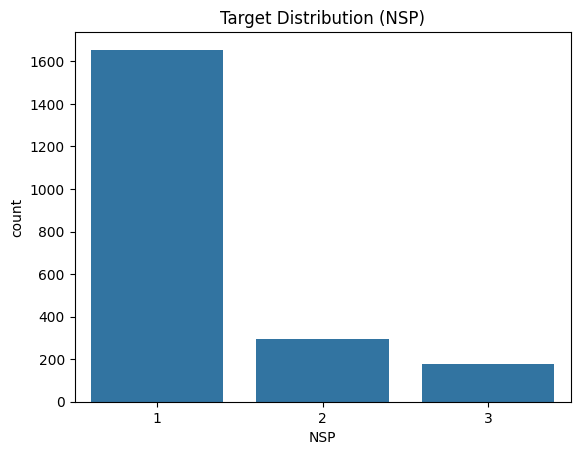

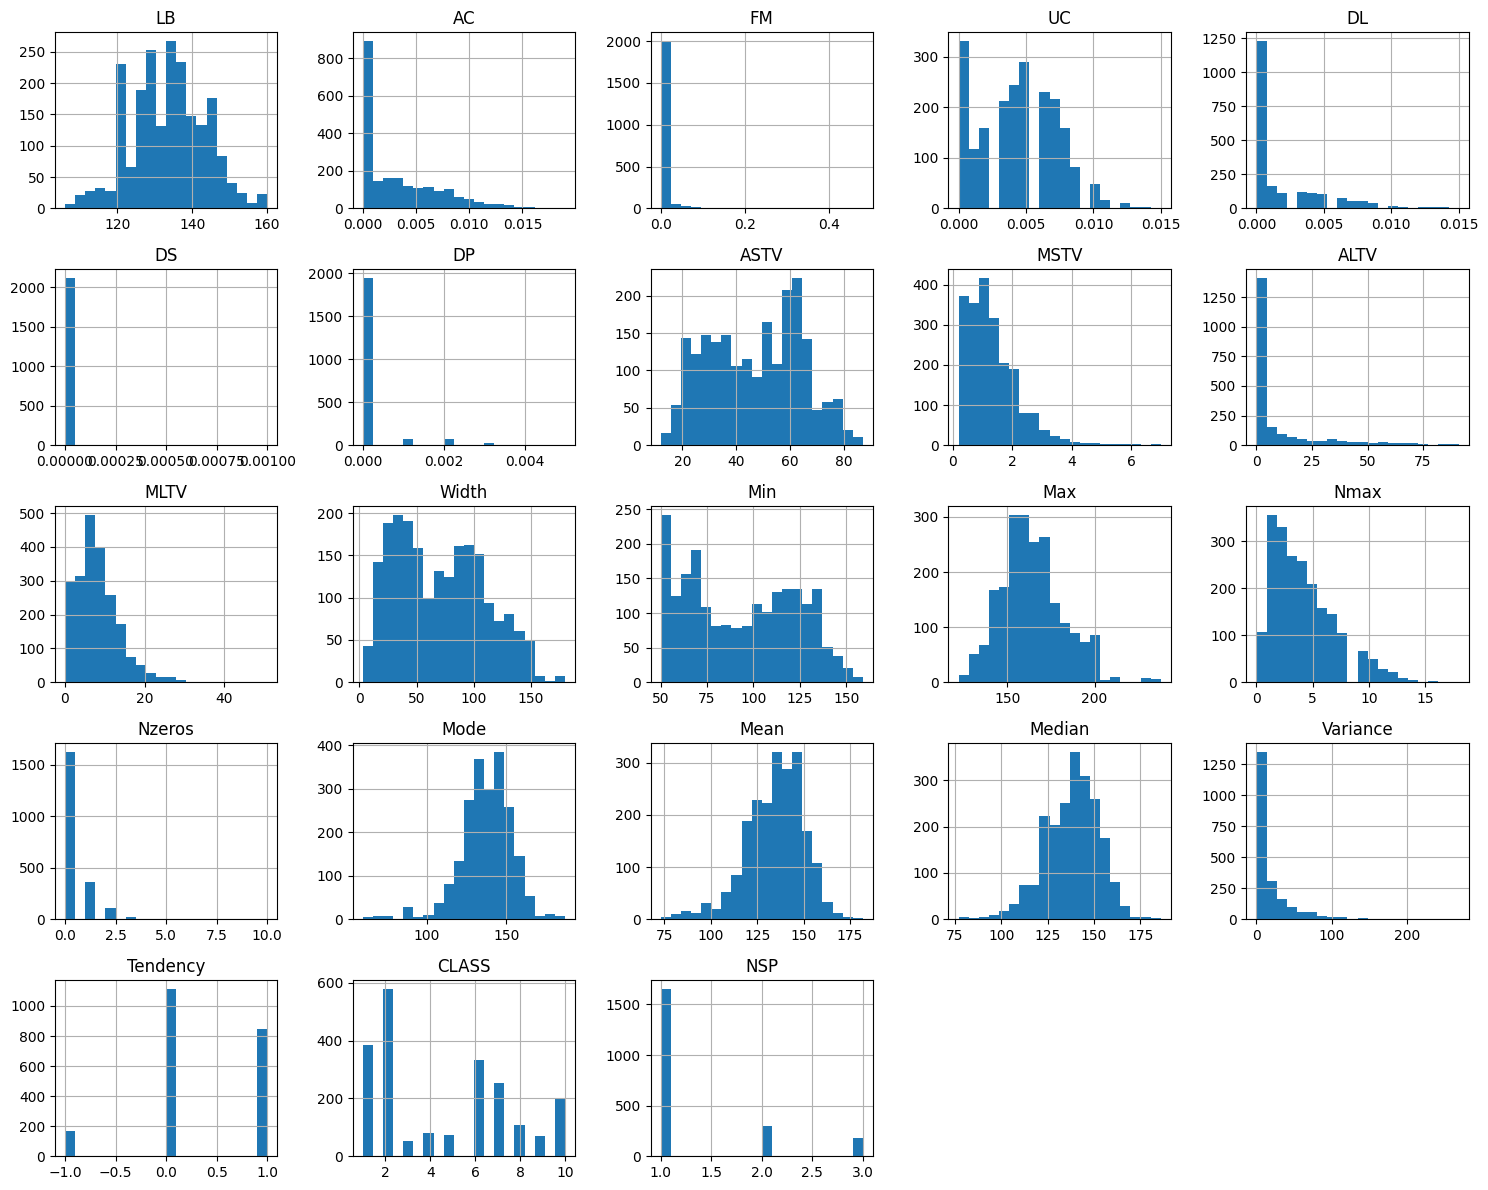

In [5]:
#Target Distribution
sns.countplot(x="NSP", data=df)
plt.title("Target Distribution (NSP)")
plt.show()

#Features Distribution
df.hist(figsize=(15, 12), bins=20)
plt.tight_layout()
plt.show()

# get all numeric features except target
features = df.drop(columns=["NSP"]).columns

The bar chart of NSP shows clear class imbalance (Normal ≫ Suspect ≫ Pathologic).
Implication: downstream modeling should emphasize balanced metrics (Balanced Accuracy, Macro-F1) rather than accuracy alone.
Strategy: employ class imbalance handling (e.g., class_weight, SMOTE) to mitigate bias toward the majority class.


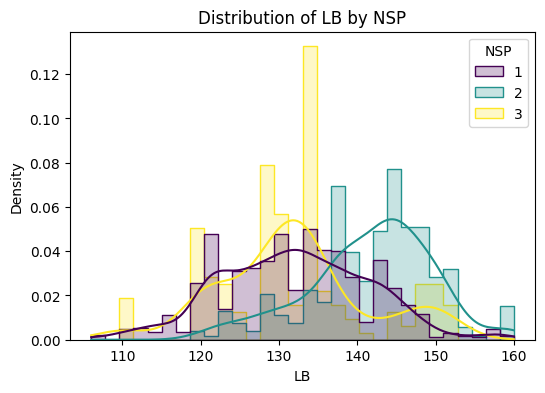

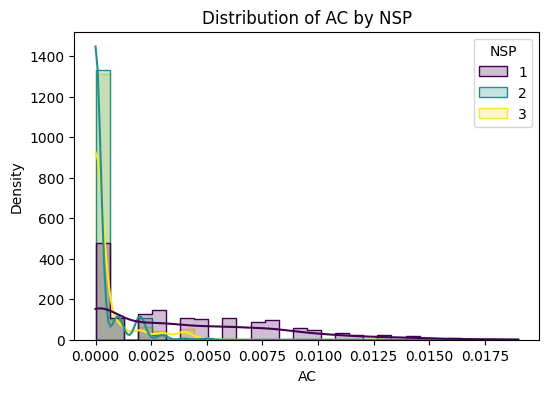

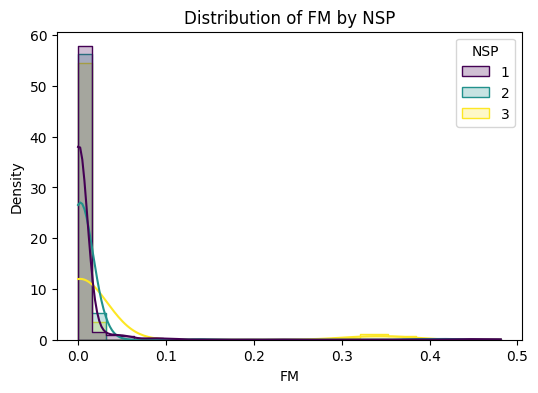

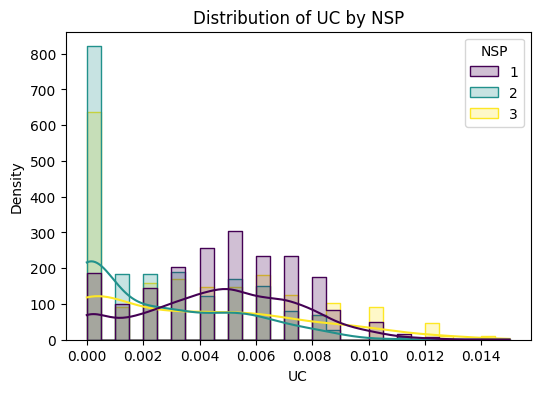

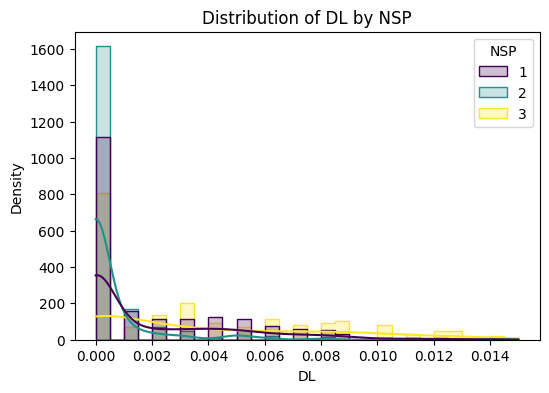

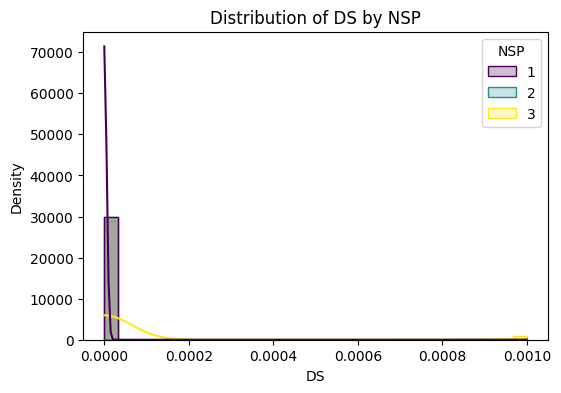

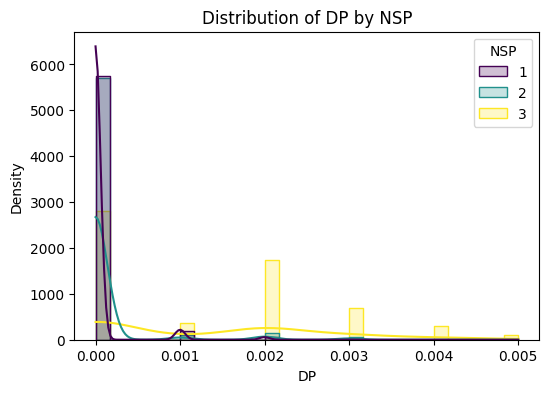

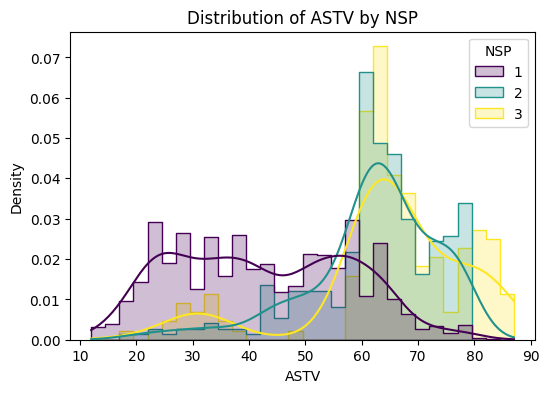

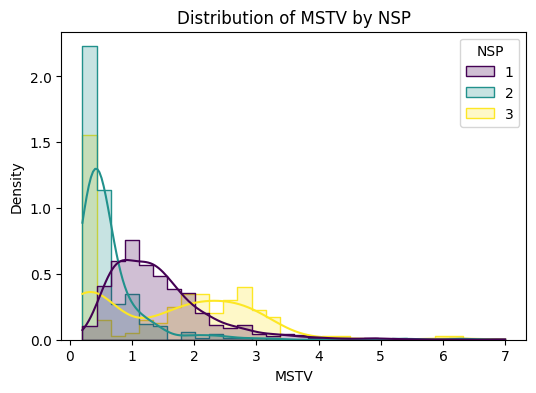

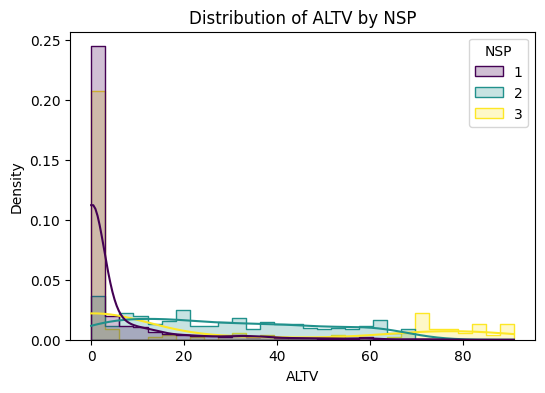

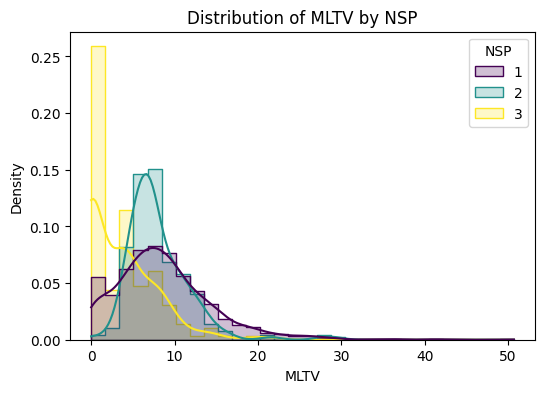

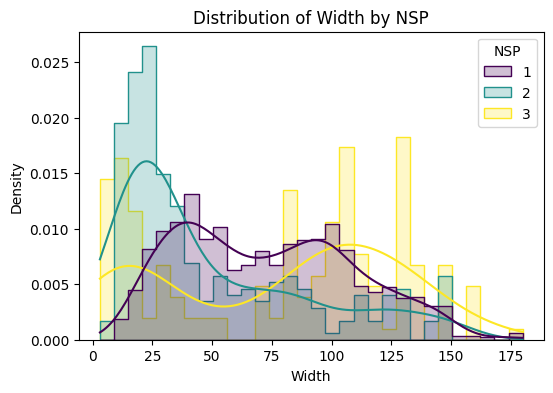

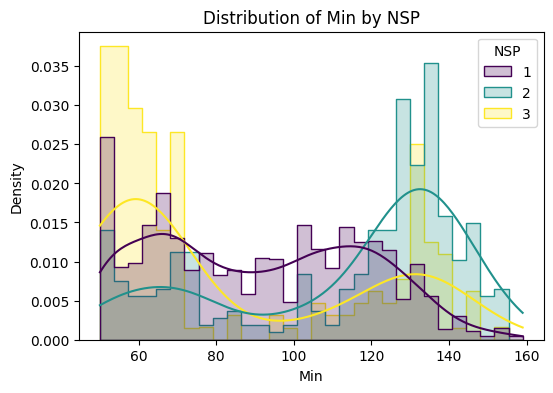

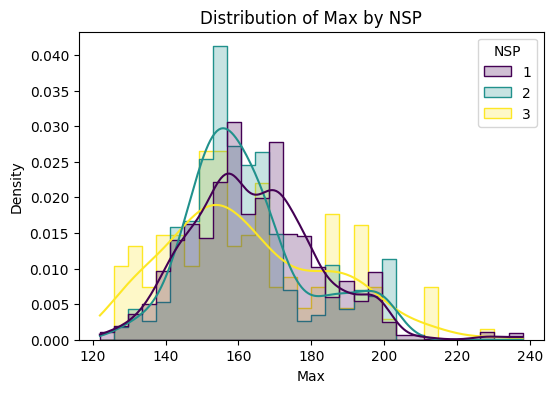

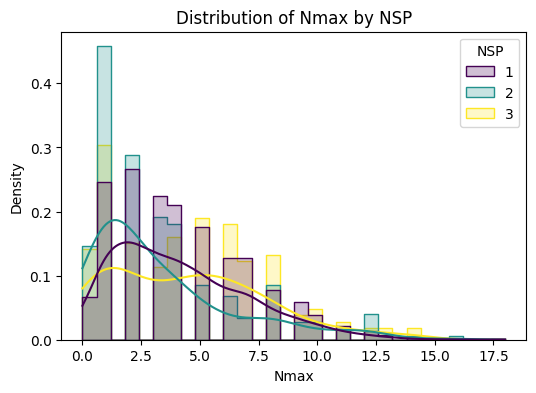

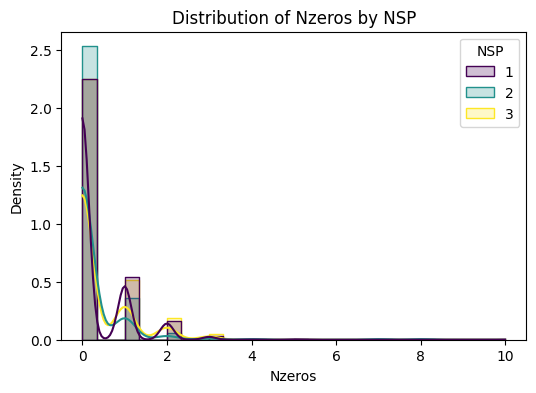

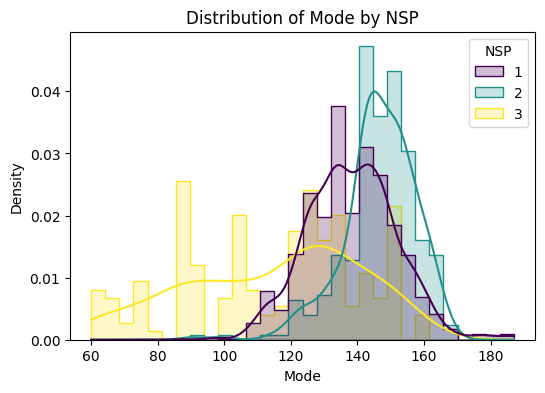

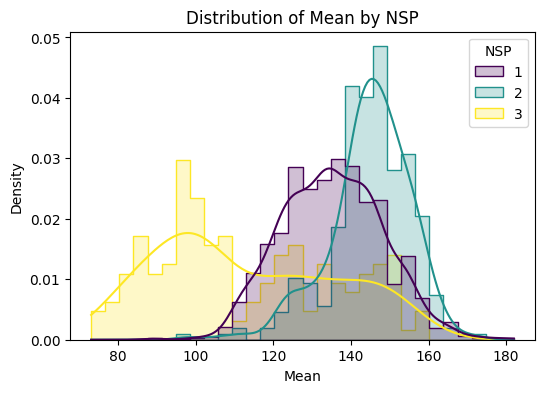

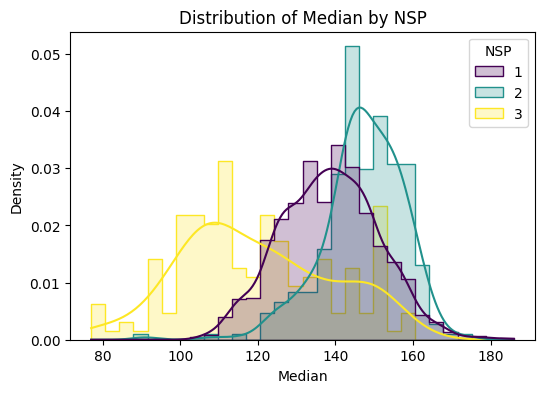

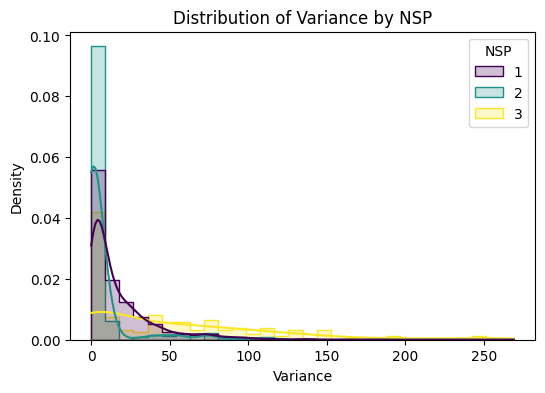

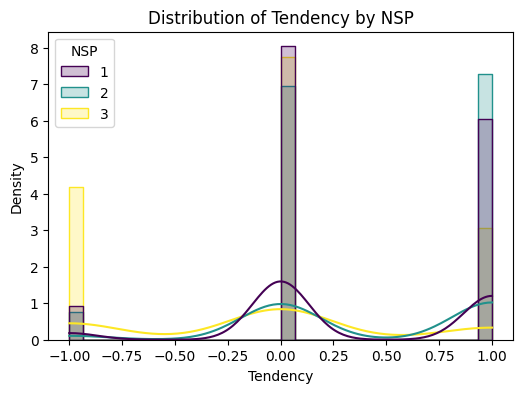

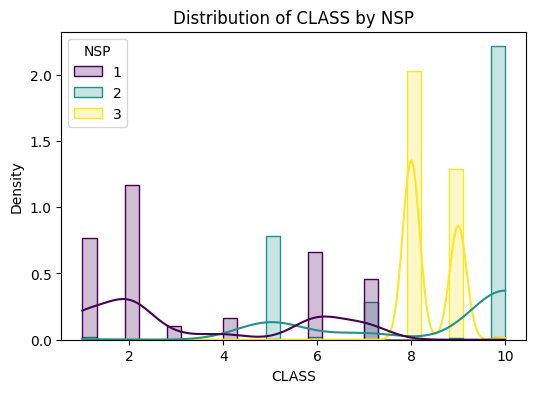

In [6]:
# plot histograms
for col in features:
    plt.figure(figsize=(6,4))
    sns.histplot(
        data=df, x=col, hue="NSP", bins=30,
        palette="viridis", kde=True, element="step", stat="density", common_norm=False
    )
    plt.title(f"Distribution of {col} by NSP")
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.show()

Histograms reveal that several features (e.g., AC, MSTV, ALTV, Nmax) are skewed or heavy-tailed.
Implication: light monotonic transforms (log1p, sqrt) may stabilize variance, aiding algorithms sensitive to scale/variance.
Note: for tree-based models (e.g., Random Forest), transformation is optional, but helps for models like logistic regression or SVM.


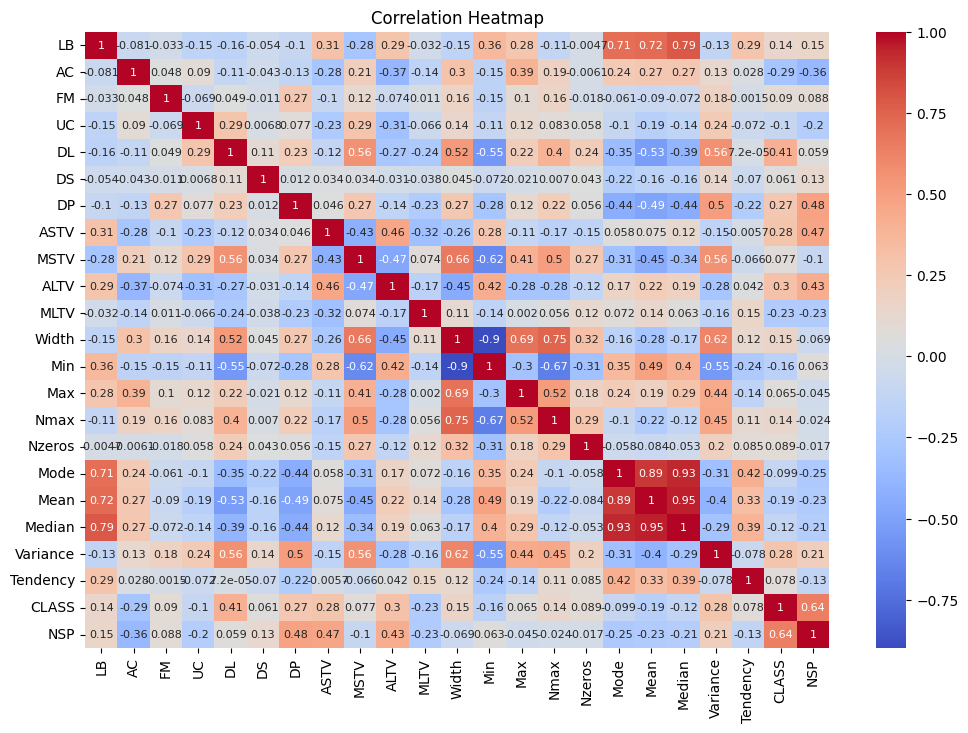

In [7]:
#Correlation Analysis 
corr = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True,annot_kws={"size":8}, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

The heatmap highlights strong correlations:
Mode, Median, Mean form one group.
Min, Width form another.
High collinearity may hinder linear models, but Random Forests and other ensemble trees are generally robust, sometimes benefiting from redundant signals.
Empirical finding: removing redundant features did not improve Random Forest performance.
Decision: retain correlated features; rely on model-based evaluation (OOB/Test scores, permutation importance) over correlation pruning.


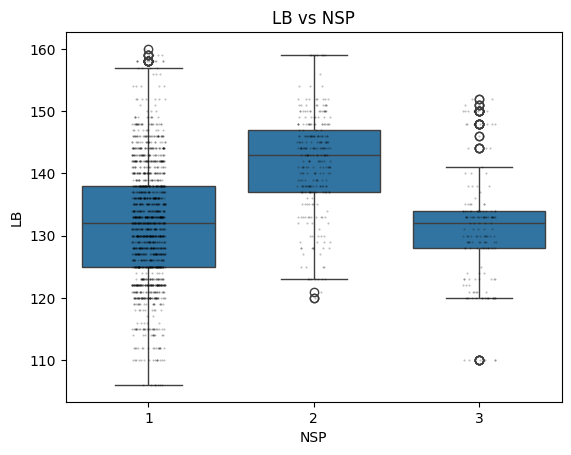

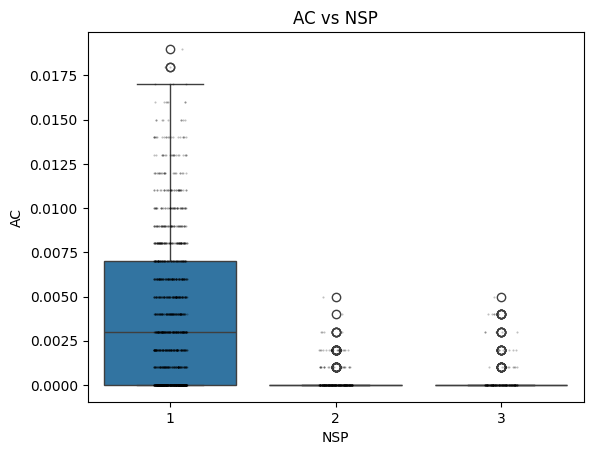

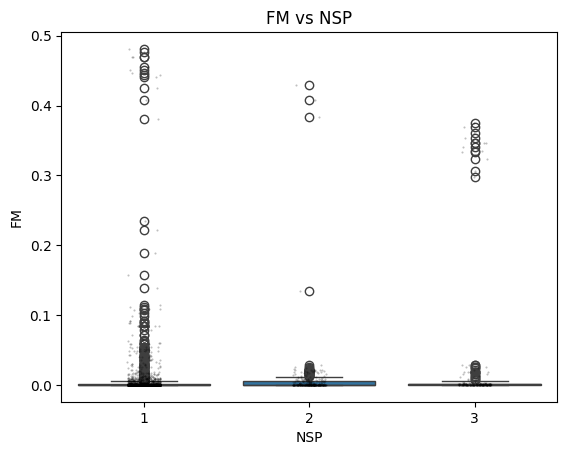

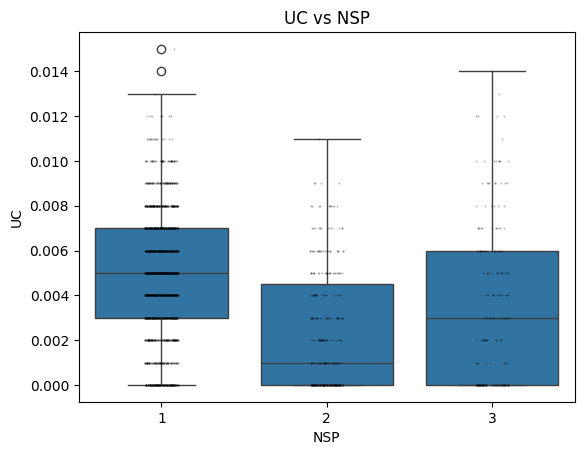

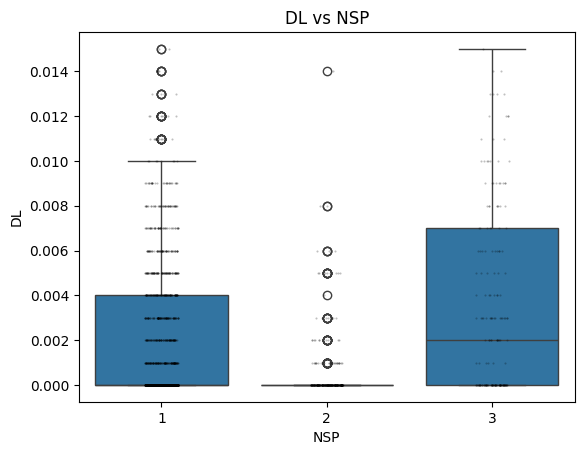

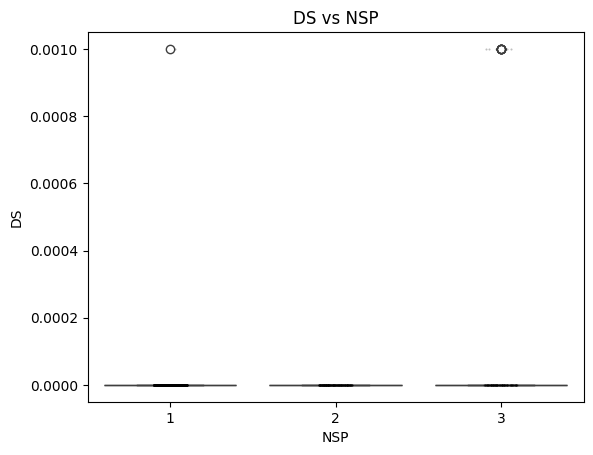

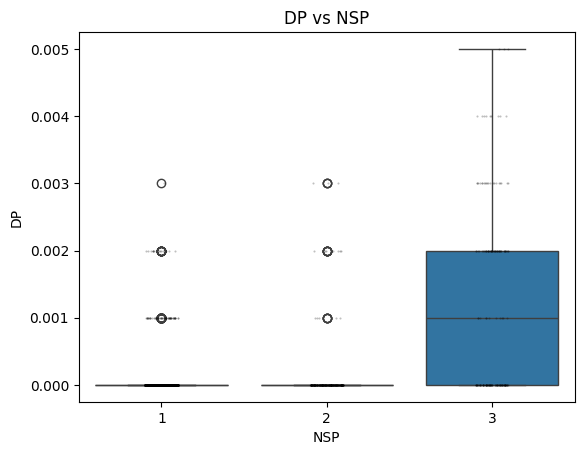

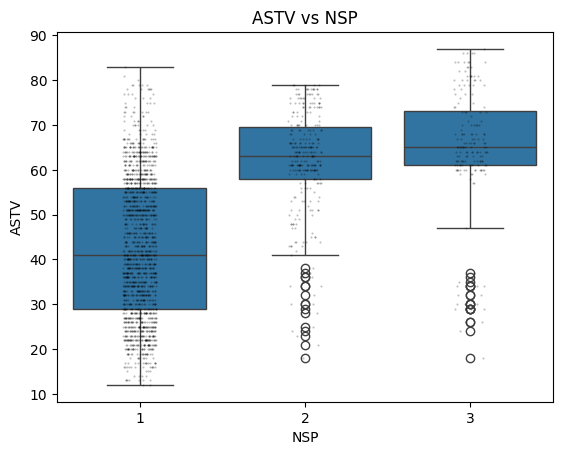

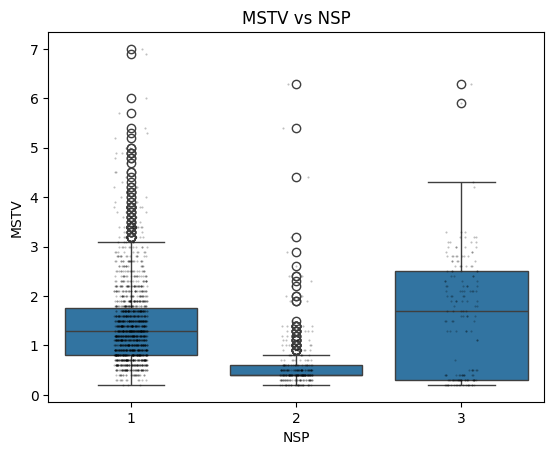

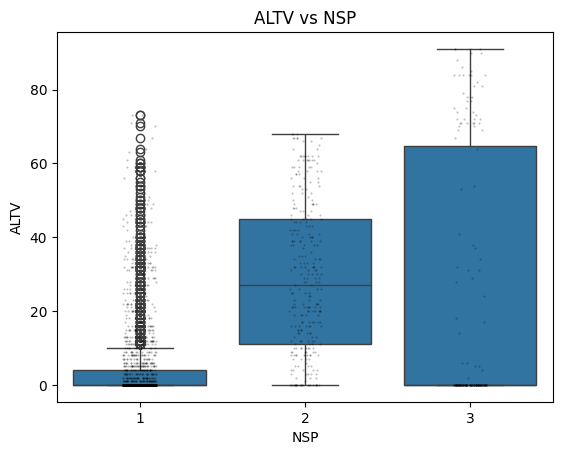

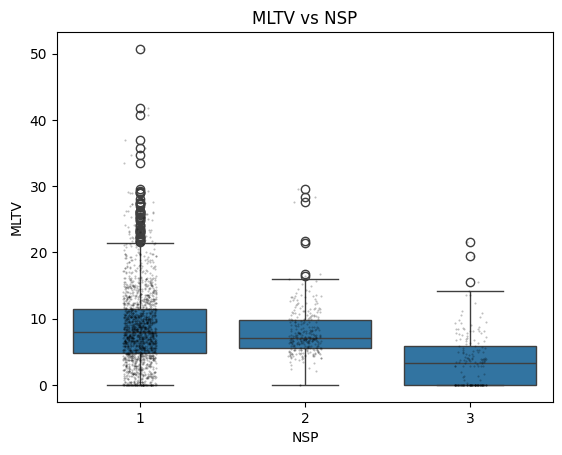

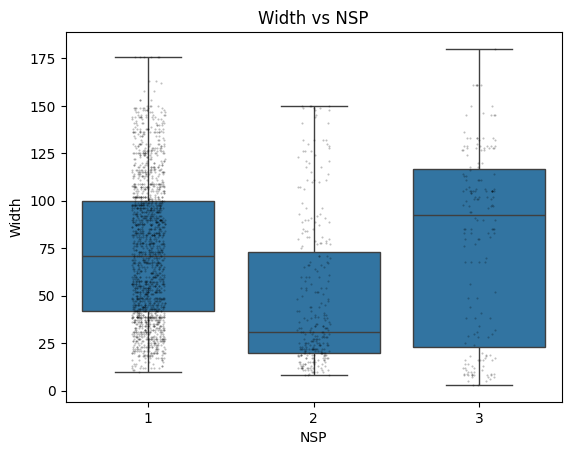

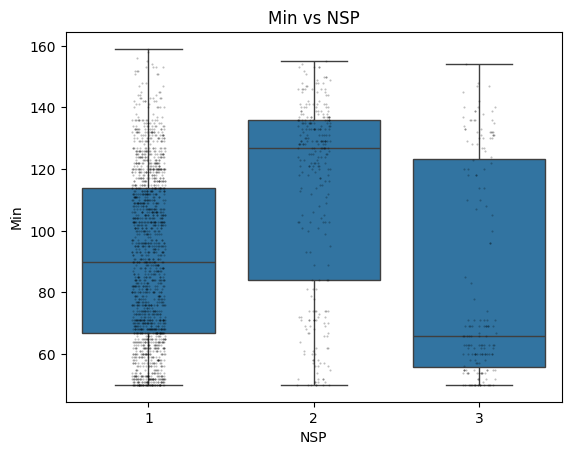

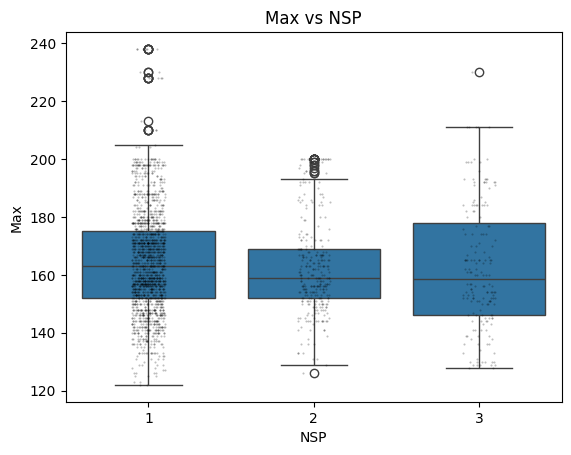

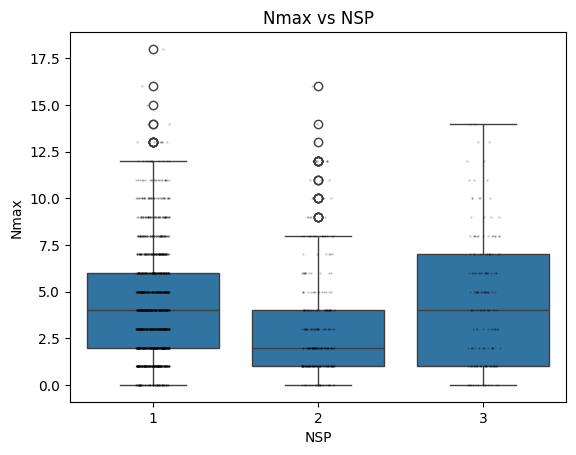

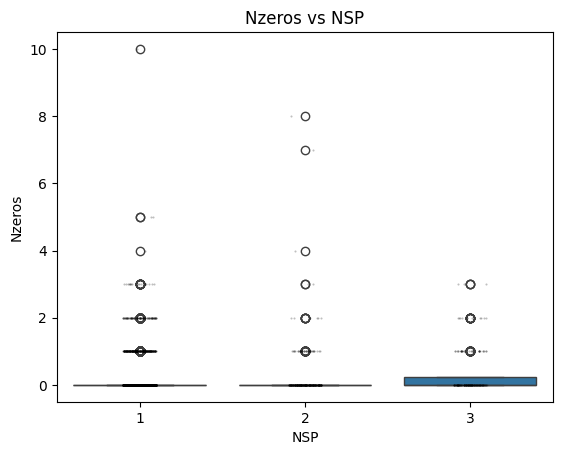

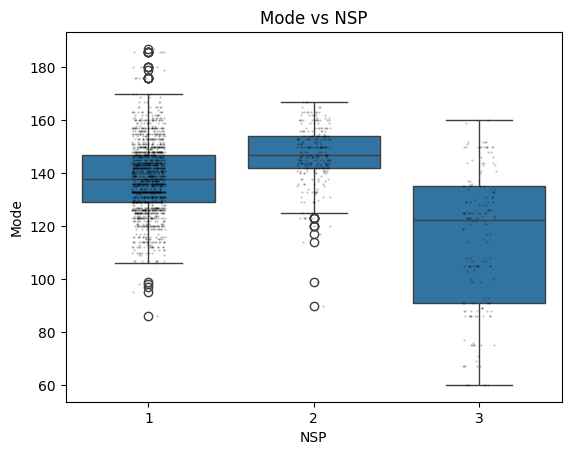

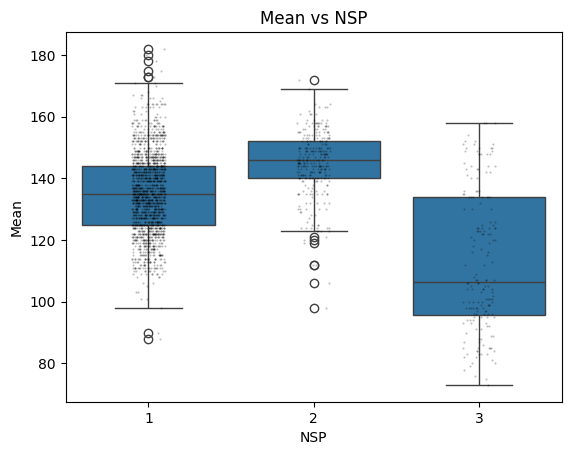

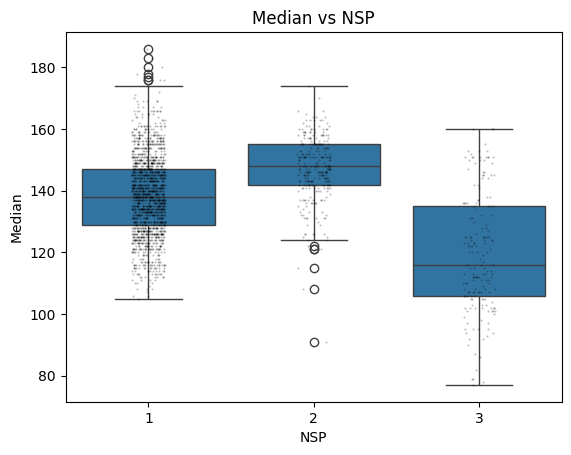

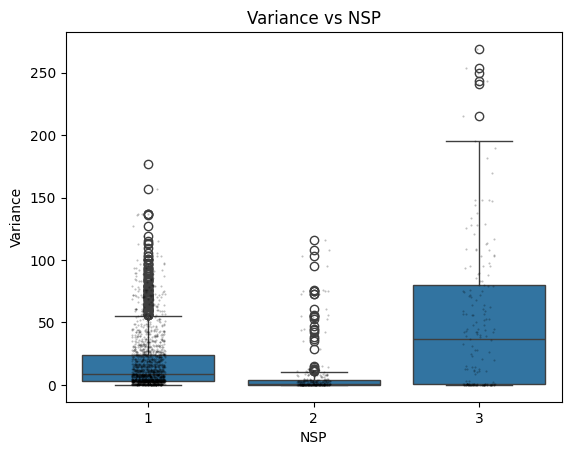

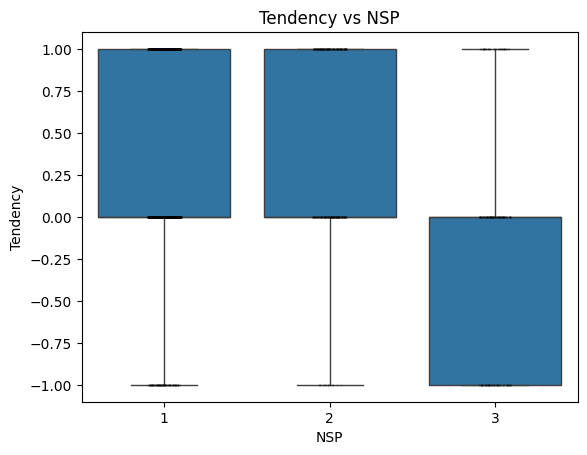

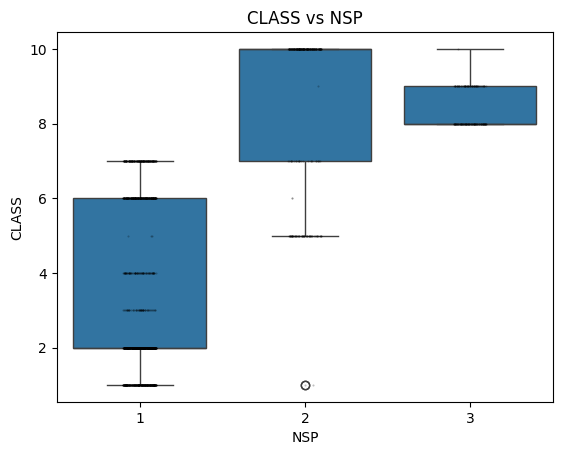

In [8]:
#Boxplot Relationship between features and targets
order = [1, 2, 3]  # NSP: 1=Normal, 2=Suspect, 3=Pathologic
for col in df.drop(columns=["NSP"]).columns:
    ax = sns.boxplot(x="NSP", y=col, data=df, order=order, showfliers=True)
    sns.stripplot(x="NSP", y=col, data=df, order=order, size=1.5, color="k", alpha=0.25)
    ax.set_title(f"{col} vs NSP")
    plt.show()

Boxplots with jitter across NSP classes indicate discriminative strength:
Features like ASTV, ALTV, AC show clear median shifts and relatively compact interquartile ranges for NSP=2/3.
Limited overlap across classes suggests high univariate discriminative power.
Even overlapping features may contribute via interactions or ratios.
This aligns with feature importance results observed later in model training.


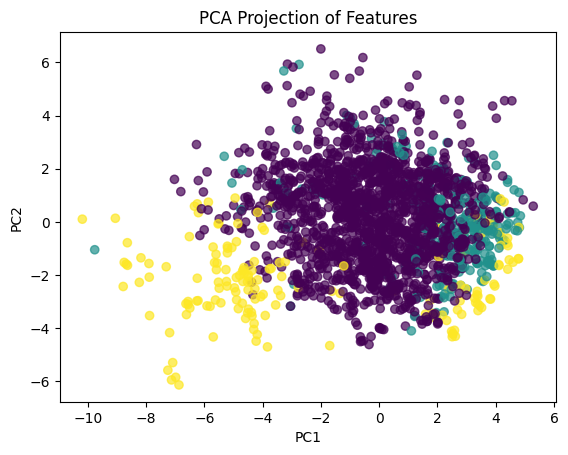

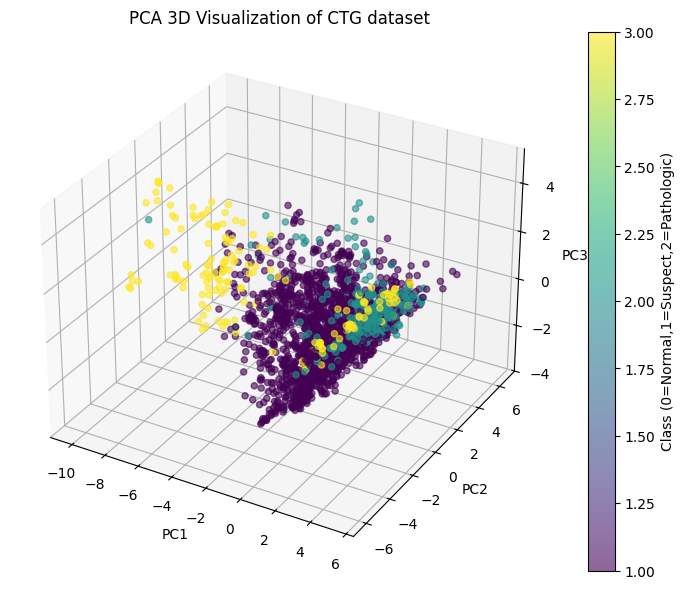

In [9]:
#PCA Projection of Features
from sklearn.decomposition import PCA

scaler_full = StandardScaler()
X_scaled = scaler_full.fit_transform(X)

X = df.drop(columns=["NSP"])
y = df["NSP"]

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap="viridis", alpha=0.7)
plt.title("PCA Projection of Features")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

#not linear or easily separable, need more complex models

pca3 = PCA(n_components=3, random_state=42)
X_pca3 = pca3.fit_transform(X_scaled)

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection="3d")

scatter = ax.scatter(
    X_pca3[:,0], X_pca3[:,1], X_pca3[:,2],
    c=y, cmap="viridis", alpha=0.6
)

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.title("PCA 3D Visualization of CTG dataset")
plt.colorbar(scatter, label="Class (0=Normal,1=Suspect,2=Pathologic)")
plt.show()

PCA scatterplots provide a linear global view:
Partial separation exists between NSP classes.
Residual overlap highlights the non-linear nature of boundaries, reinforcing the need for non-linear classifiers.
PCA is used only for visualization, confirming that classification requires multi-feature models.


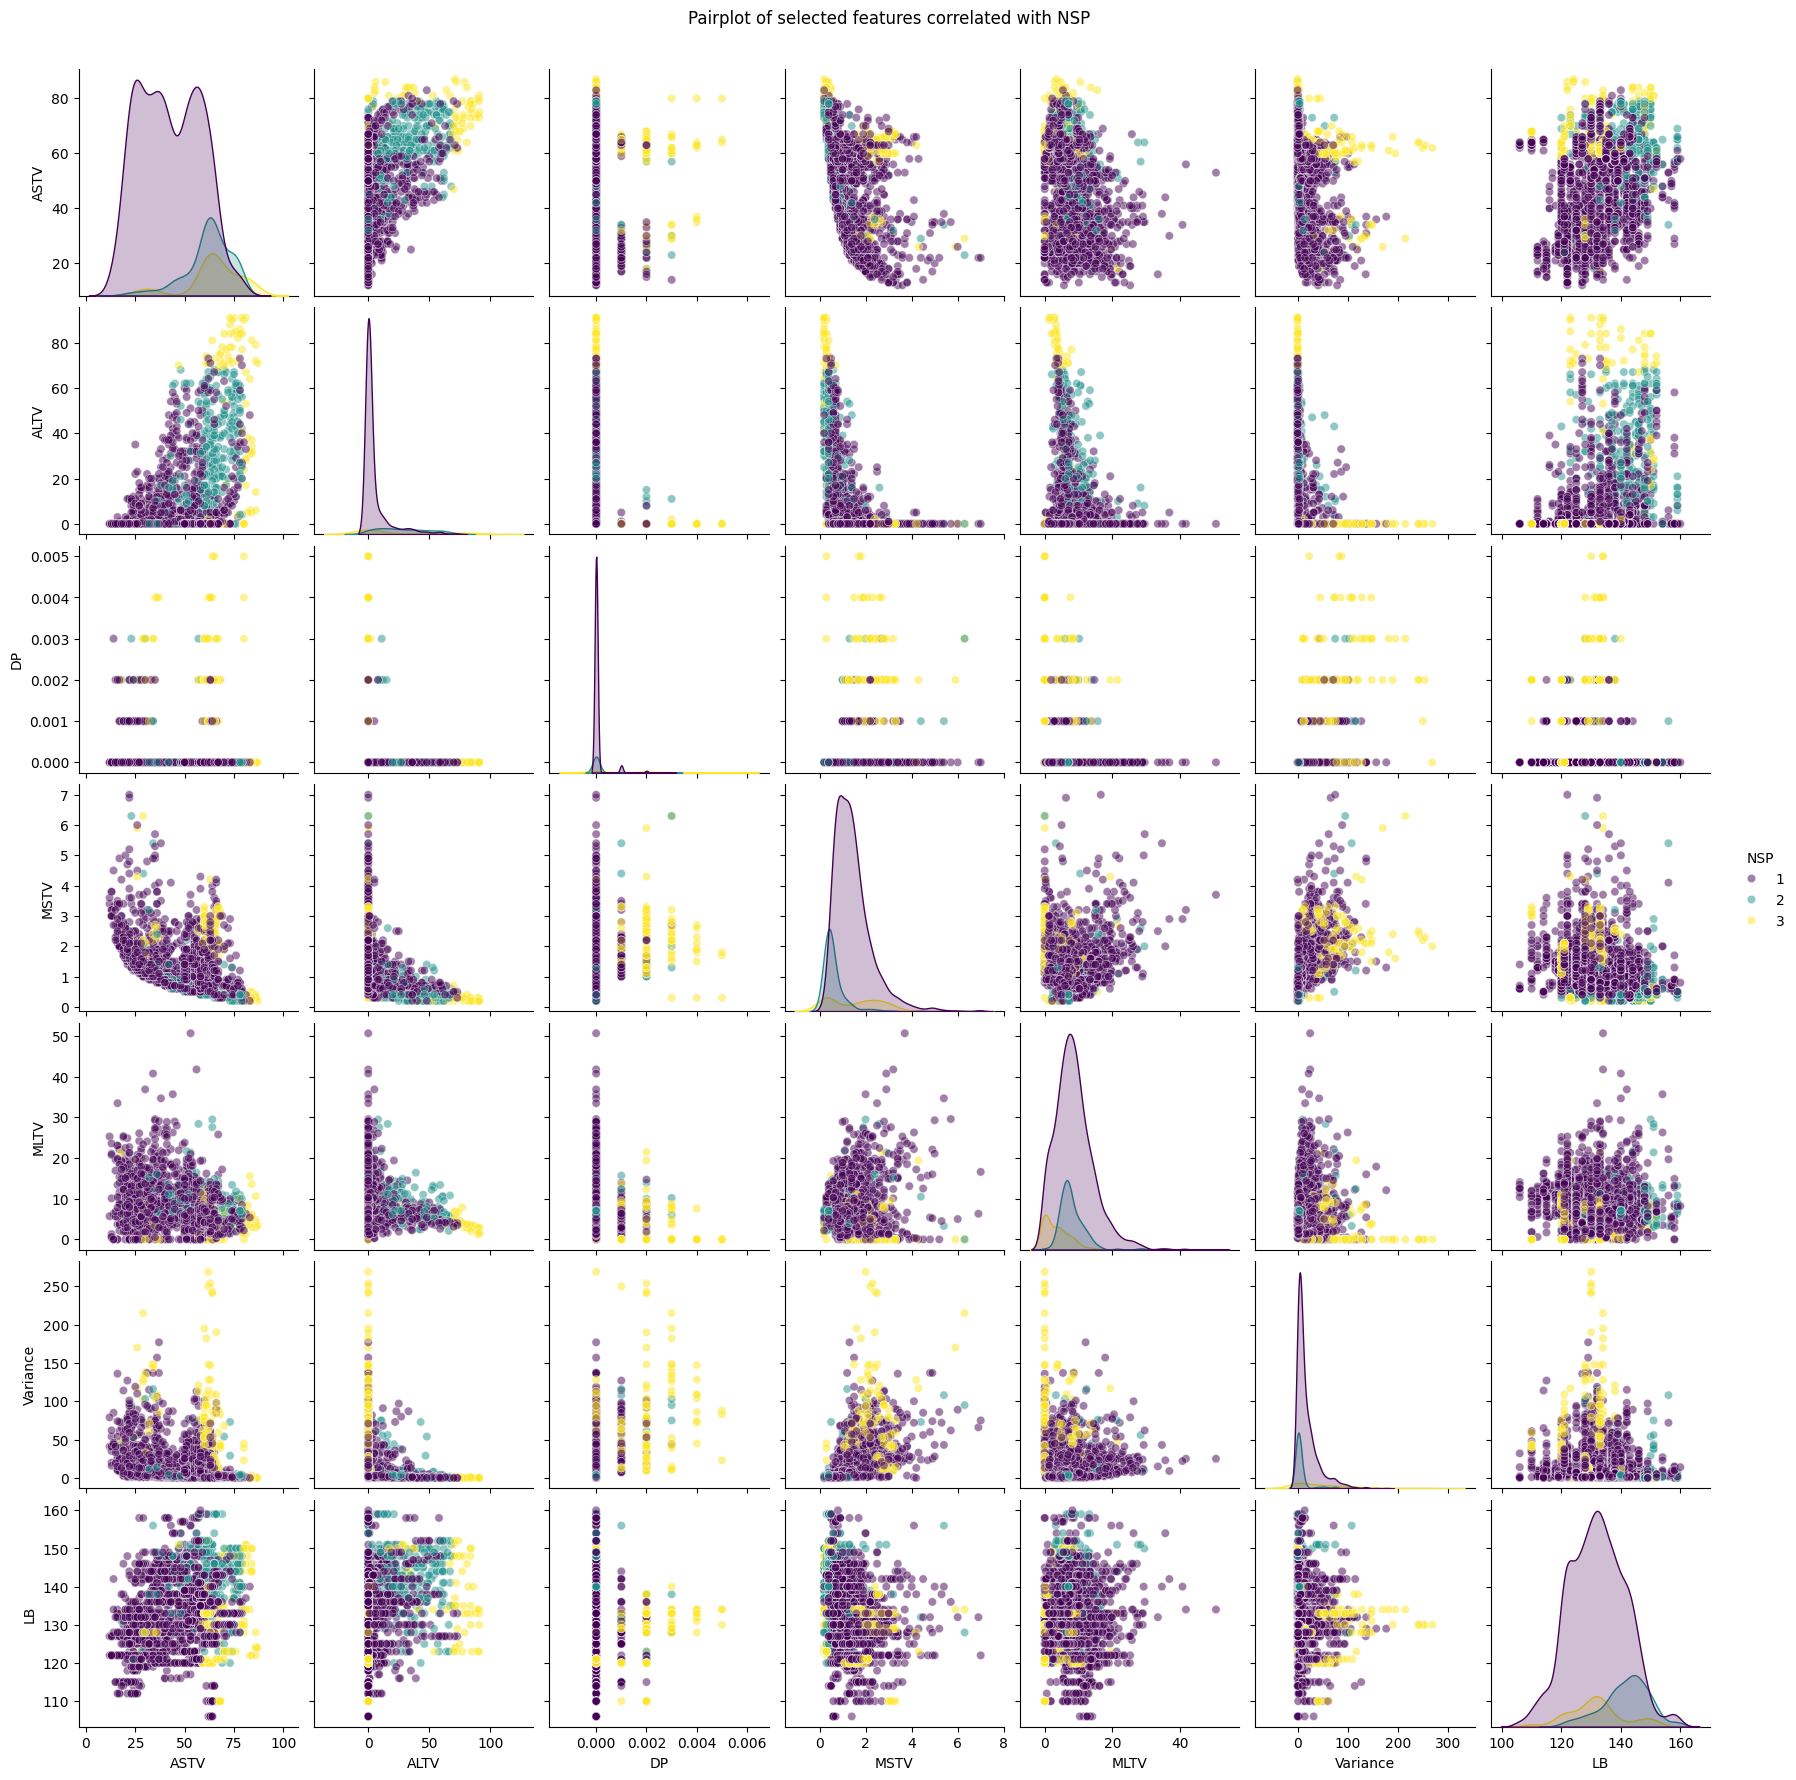

In [10]:
#pairplot

features_for_pairplot = ["ASTV", "ALTV","DP", "MSTV", "MLTV", "Variance", "LB", "NSP"]
df_subset = df[features_for_pairplot]

# pairplot
sns.pairplot(df_subset, hue="NSP", diag_kind="kde", palette="viridis", plot_kws={'alpha':0.5})
plt.suptitle("Pairplot of selected features correlated with NSP", y=1.02)
plt.show()

Pairplots (selected features: ASTV, ALTV, DP, MSTV, MLTV, Variance, LB, NSP) reveal interaction patterns:
Examples: ASTV–ALTV and ALTV–MLTV show band- or fan-shaped separation.
These motivate engineered interaction features (ratios, differences, ranges).
We implemented such feature engineering (in below cells for RF-FE):
Original features: 21
Expanded features: 38
Random Forest performance improved:
Metric	Before	After
Accuracy	0.958	0.960
Balanced Accuracy	0.928	0.929
Macro-F1	0.932	0.935


Removing redundant features with high correlation did not improve performance for our main model, Random Forest, as RF is robust to multicollinearity and can even benefit from redundant signals.
Here we comment it out

In [11]:
"""
Xn = df.drop(columns=["NSP"]).select_dtypes(include=[np.number])
y  = df["NSP"].to_numpy().reshape(-1)

corr  = Xn.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
th = 0.85

to_drop, kept = set(), set()
for col in upper.columns:
    if col in to_drop or col in kept:
        continue
    grp = [col] + [r for r in upper.index[upper[col] > th].tolist()
                   if r not in to_drop and r not in kept]
    if len(grp) <= 1:
        continue
    scores = {c: (abs(np.corrcoef(Xn[c], y)[0,1]) if np.std(Xn[c])>0 else 0.0) for c in grp}
    best = max(scores, key=scores.get)
    kept.add(best)
    to_drop.update([c for c in grp if c != best])
to_drop -= kept

print("Dropping:", sorted(to_drop))
df1 = df.drop(columns=list(to_drop))

#redo split after dropping redundant features
pack = preprocess_ctg(df=df1, target_col="NSP", test_size=0.2, random_state=3407, use_smote=True)
X_tr, y_tr = pack["X_train"], pack["y_train"]
X_te, y_te = pack["X_test"],  pack["y_test"]

print("Train/Test shapes:", X_tr.shape, X_te.shape)
print("Train label counts:", np.bincount(y_tr))
feat_names = pack["feature_names"]
print("Num features:", len(feat_names))
print("Dropped features:", sorted(to_drop))
print("Kept features:", sorted(feat_names)) 
"""

'\nXn = df.drop(columns=["NSP"]).select_dtypes(include=[np.number])\ny  = df["NSP"].to_numpy().reshape(-1)\n\ncorr  = Xn.corr().abs()\nupper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))\nth = 0.85\n\nto_drop, kept = set(), set()\nfor col in upper.columns:\n    if col in to_drop or col in kept:\n        continue\n    grp = [col] + [r for r in upper.index[upper[col] > th].tolist()\n                   if r not in to_drop and r not in kept]\n    if len(grp) <= 1:\n        continue\n    scores = {c: (abs(np.corrcoef(Xn[c], y)[0,1]) if np.std(Xn[c])>0 else 0.0) for c in grp}\n    best = max(scores, key=scores.get)\n    kept.add(best)\n    to_drop.update([c for c in grp if c != best])\nto_drop -= kept\n\nprint("Dropping:", sorted(to_drop))\ndf1 = df.drop(columns=list(to_drop))\n\n#redo split after dropping redundant features\npack = preprocess_ctg(df=df1, target_col="NSP", test_size=0.2, random_state=3407, use_smote=True)\nX_tr, y_tr = pack["X_train"], pack["y_train"]\nX_te, y

Model Building (Baseline)

In this section, we experimented with several common classifiers including: LR, DT, RF, ExtraTrees, SCV, XGB, using baseline models and compared their performances with a focus on Macro-F1 and Balanced Accuracy. Based on these results, we selected Random Forest (RF) as the primary model for further feature engineering and subsequent hyperparameter tuning. We also report the feature importance for each model to better understand the contribution of individual variables and to demonstrate that the selected features are both important and clinically meaningful.

LR

=== Logistic Regression (hold-out) ===
Accuracy: 0.8826291079812206
Balanced Accuracy: 0.8599716055505313
Macro F1: 0.8112436769579627
              precision    recall  f1-score   support

           0     0.9770    0.8976    0.9356       332
           1     0.5802    0.7966    0.6714        59
           2     0.7750    0.8857    0.8267        35

    accuracy                         0.8826       426
   macro avg     0.7774    0.8600    0.8112       426
weighted avg     0.9055    0.8826    0.8901       426



/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


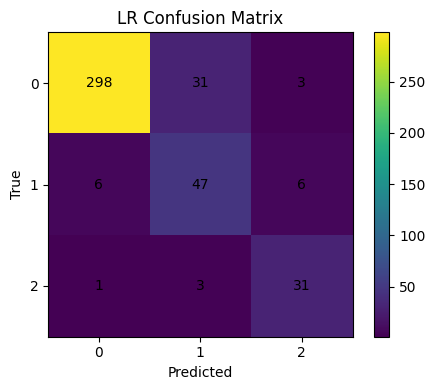

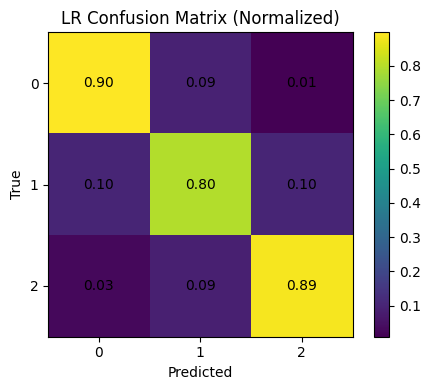

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score, f1_score
)
log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=3407,
    solver="lbfgs",       #what solver to use
    multi_class="auto"
)
log_reg.fit(X_tr, y_tr)
y_pred_log = log_reg.predict(X_te)

print("=== Logistic Regression (hold-out) ===")
print("Accuracy:", accuracy_score(y_te, y_pred_log))
print("Balanced Accuracy:", balanced_accuracy_score(y_te, y_pred_log))
print("Macro F1:", f1_score(y_te, y_pred_log, average="macro"))
print(classification_report(y_te, y_pred_log, digits=4))

labels = [0,1,2]
cm = confusion_matrix(y_te, y_pred_log, labels=labels)

plt.figure(figsize=(5,4))
ax = plt.gca()
im = ax.imshow(cm)
plt.colorbar(im, ax=ax)
ax.set_xticks(range(len(labels))); ax.set_yticks(range(len(labels)))
ax.set_xticklabels(labels); ax.set_yticklabels(labels)
ax.set_xlabel("Predicted"); ax.set_ylabel("True"); ax.set_title("LR Confusion Matrix")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i,j], ha="center", va="center")
plt.tight_layout(); plt.show()

# normalized confusion matrix
cmn = cm.astype(float) / cm.sum(axis=1, keepdims=True)
plt.figure(figsize=(5,4)); ax = plt.gca()
im = ax.imshow(cmn); plt.colorbar(im, ax=ax)
ax.set_xticks(range(len(labels))); ax.set_yticks(range(len(labels)))
ax.set_xticklabels(labels); ax.set_yticklabels(labels)
ax.set_xlabel("Predicted"); ax.set_ylabel("True"); ax.set_title("LR Confusion Matrix (Normalized)")
for i in range(cmn.shape[0]):
    for j in range(cmn.shape[1]):
        ax.text(j, i, f"{cmn[i, j]:.2f}", ha="center", va="center")
plt.tight_layout(); plt.show()

          imp_abs_max  imp_abs_mean
AC           2.936440      2.202330
LB           2.103252      1.577439
ASTV         2.080159      1.560119
Mode         1.583438      1.187578
Median       1.505912      1.129434
Mean         1.429697      1.072273
Variance     1.387551      1.040664
Nmax         1.310133      0.982600
DP           1.118818      0.839113
ALTV         0.815182      0.611387
Max          0.657927      0.493446
FM           0.634835      0.476126
MSTV         0.551774      0.413830
UC           0.505884      0.379413
DL           0.354889      0.266167


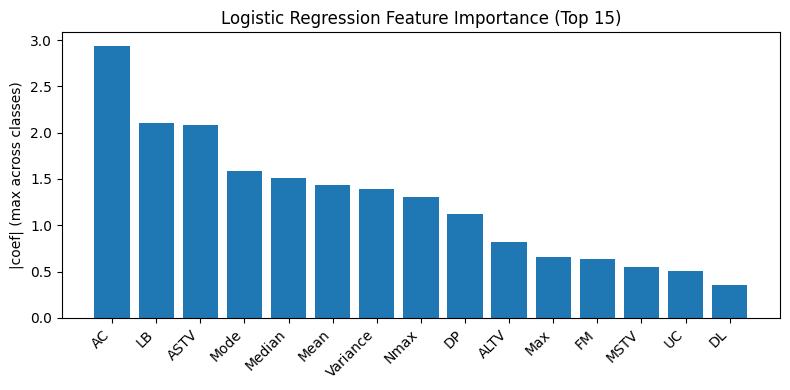


Top + for class0:
AC      2.936440
Mode    0.873601
MSTV    0.551774
UC      0.505884
Nmax    0.475609
Name: class0, dtype: float64
Top - for class0:
ASTV       -1.774969
DP         -1.118818
Variance   -0.944399
Mean       -0.895256
Max        -0.657927
Name: class0, dtype: float64

Top + for class1:
Mean      1.429697
Median    1.097518
Nmax      0.834524
Mode      0.709836
DP        0.318792
Name: class1, dtype: float64
Top - for class1:
LB         -1.783134
AC         -1.525535
Variance   -0.443153
ASTV       -0.305190
MSTV       -0.269385
Name: class1, dtype: float64

Top + for class2:
LB          2.103252
ASTV        2.080159
Variance    1.387551
ALTV        0.815182
DP          0.800026
Name: class2, dtype: float64
Top - for class2:
Mode     -1.583438
Median   -1.505912
AC       -1.410904
Nmax     -1.310133
Mean     -0.534441
Name: class2, dtype: float64


In [13]:
#feature importances in Logistic Regression
feat = pack["feature_names"]
coef = np.asarray(log_reg.coef_)         
if coef.ndim == 1: coef = coef.reshape(1, -1)

coef_df = pd.DataFrame(coef, columns=feat, index=[f"class{k}" for k in range(coef.shape[0])]).T
coef_df["imp_abs_max"]  = coef_df.abs().max(axis=1)   
coef_df["imp_abs_mean"] = coef_df.abs().mean(axis=1)   

top = coef_df.sort_values("imp_abs_max", ascending=False).head(15)
print(top[["imp_abs_max","imp_abs_mean"]])

plt.figure(figsize=(8,4))
plt.bar(top.index, top["imp_abs_max"].values)
plt.xticks(rotation=45, ha="right")
plt.ylabel("|coef| (max across classes)")
plt.title("Logistic Regression Feature Importance (Top 15)")
plt.tight_layout()
plt.show()

for k in range(coef.shape[0]):
    print(f"\nTop + for class{k}:")
    print(coef_df.sort_values(f"class{k}", ascending=False)[f"class{k}"].head(5))
    print(f"Top - for class{k}:")
    print(coef_df.sort_values(f"class{k}", ascending=True)[f"class{k}"].head(5))


DT

=== Decision Tree (hold-out) ===
Accuracy: 0.9248826291079812
Balanced Accuracy: 0.8811463772766611
Macro F1: 0.8601033741595606
Confusion Matrix:
 [[317   9   6]
 [ 10  44   5]
 [  2   0  33]]
              precision    recall  f1-score   support

           0     0.9635    0.9548    0.9592       332
           1     0.8302    0.7458    0.7857        59
           2     0.7500    0.9429    0.8354        35

    accuracy                         0.9249       426
   macro avg     0.8479    0.8811    0.8601       426
weighted avg     0.9275    0.9249    0.9250       426



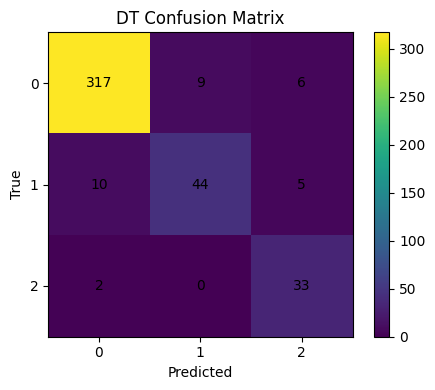

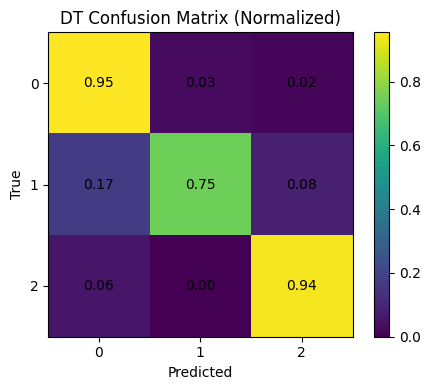

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, classification_report, confusion_matrix

dt = DecisionTreeClassifier(
    criterion="gini",      # "entropy"/"log_loss"
    max_depth= None,        # see if overfitting, set to 6~12
    min_samples_leaf=5, 
    class_weight= None,  # SMOTE
    random_state=3407
)
dt.fit(X_tr, y_tr)
y_pred_dt = dt.predict(X_te)

print("=== Decision Tree (hold-out) ===")
print("Accuracy:", accuracy_score(y_te, y_pred_dt))
print("Balanced Accuracy:", balanced_accuracy_score(y_te, y_pred_dt))
print("Macro F1:", f1_score(y_te, y_pred_dt, average="macro"))
print("Confusion Matrix:\n", confusion_matrix(y_te, y_pred_dt))
print(classification_report(y_te, y_pred_dt, digits=4))

# confusion matrix
labels = [0,1,2]
cm = confusion_matrix(y_te, y_pred_dt, labels=labels)

plt.figure(figsize=(5,4)); ax = plt.gca()
im = ax.imshow(cm); plt.colorbar(im, ax=ax)
ax.set_xticks(range(len(labels))); ax.set_yticks(range(len(labels)))
ax.set_xticklabels(labels); ax.set_yticklabels(labels)
ax.set_xlabel("Predicted"); ax.set_ylabel("True"); ax.set_title("DT Confusion Matrix")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center")
plt.tight_layout(); plt.show()

# normalized confusion matrix
cmn = cm.astype(float) / cm.sum(axis=1, keepdims=True)
plt.figure(figsize=(5,4)); ax = plt.gca()
im = ax.imshow(cmn); plt.colorbar(im, ax=ax)
ax.set_xticks(range(len(labels))); ax.set_yticks(range(len(labels)))
ax.set_xticklabels(labels); ax.set_yticklabels(labels)
ax.set_xlabel("Predicted"); ax.set_ylabel("True"); ax.set_title("DT Confusion Matrix (Normalized)")
for i in range(cmn.shape[0]):
    for j in range(cmn.shape[1]):
        ax.text(j, i, f"{cmn[i, j]:.2f}", ha="center", va="center")
plt.tight_layout(); plt.show()


Top 15 importances:
 Mean     0.295154
MSTV     0.237760
ALTV     0.141632
ASTV     0.120732
AC       0.060398
Mode     0.032408
DP       0.028366
Max      0.025999
LB       0.013457
MLTV     0.012163
UC       0.009246
FM       0.009155
Nmax     0.004146
Min      0.003445
Width    0.002876
dtype: float64


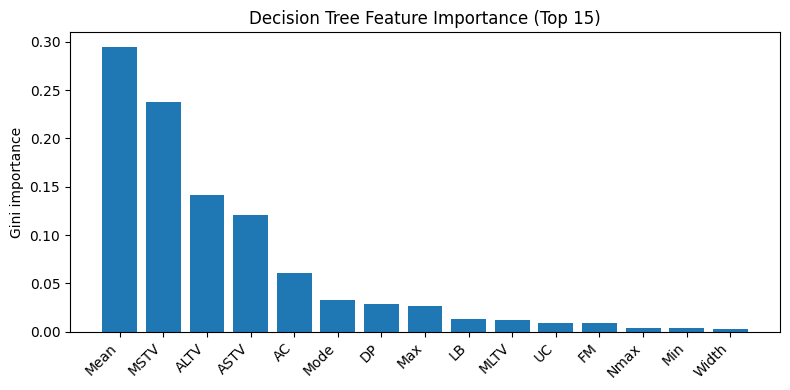

In [15]:
# feature importances in Decision Tree
feat = pack["feature_names"] if "pack" in globals() and "feature_names" in pack else [f"f{i}" for i in range(X_tr.shape[1])]
imp = pd.Series(dt.feature_importances_, index=feat).sort_values(ascending=False)

print("Top 15 importances:\n", imp.head(15))

plt.figure(figsize=(8,4))
plt.bar(imp.index[:15], imp.values[:15])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Gini importance")
plt.title("Decision Tree Feature Importance (Top 15)")
plt.tight_layout(); plt.show()


RF

=== Random Forest (hold-out) ===
Accuracy: 0.9577464788732394
Balanced Accuracy: 0.9277225123253304
Macro F1: 0.9317882030056719
              precision    recall  f1-score   support

           0     0.9730    0.9759    0.9744       332
           1     0.8644    0.8644    0.8644        59
           2     0.9706    0.9429    0.9565        35

    accuracy                         0.9577       426
   macro avg     0.9360    0.9277    0.9318       426
weighted avg     0.9577    0.9577    0.9577       426



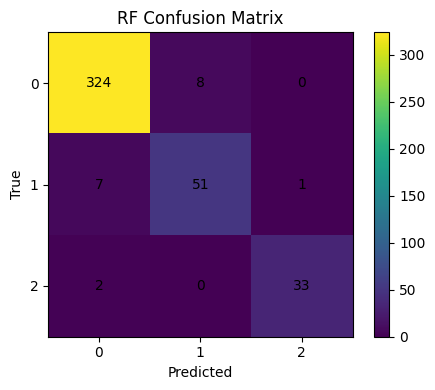

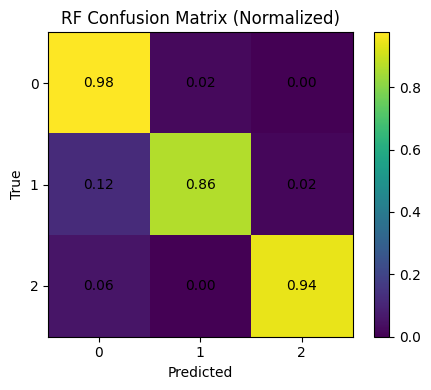

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score,
    classification_report, confusion_matrix
)

rf = RandomForestClassifier(
    n_estimators=600,
    max_depth=None,
    max_features="sqrt",
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight="balanced_subsample",
    random_state=3407,
    n_jobs=-1
)
rf.fit(X_tr, y_tr)
y_pred_rf = rf.predict(X_te)

print("=== Random Forest (hold-out) ===")
print("Accuracy:", accuracy_score(y_te, y_pred_rf))
print("Balanced Accuracy:", balanced_accuracy_score(y_te, y_pred_rf))
print("Macro F1:", f1_score(y_te, y_pred_rf, average="macro"))
print(classification_report(y_te, y_pred_rf, digits=4))

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

labels = [0,1,2]
cm = confusion_matrix(y_te, y_pred_rf, labels=labels)

plt.figure(figsize=(5,4)); ax = plt.gca()
im = ax.imshow(cm); plt.colorbar(im, ax=ax)
ax.set_xticks(range(len(labels))); ax.set_yticks(range(len(labels)))
ax.set_xticklabels(labels); ax.set_yticklabels(labels)
ax.set_xlabel("Predicted"); ax.set_ylabel("True"); ax.set_title("RF Confusion Matrix")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center")
plt.tight_layout(); plt.show()

# normalized confusion matrix
cmn = cm.astype(float) / cm.sum(axis=1, keepdims=True)
plt.figure(figsize=(5,4)); ax = plt.gca()
im = ax.imshow(cmn); plt.colorbar(im, ax=ax)
ax.set_xticks(range(len(labels))); ax.set_yticks(range(len(labels)))
ax.set_xticklabels(labels); ax.set_yticklabels(labels)
ax.set_xlabel("Predicted"); ax.set_ylabel("True"); ax.set_title("RF Confusion Matrix (Normalized)")
for i in range(cmn.shape[0]):
    for j in range(cmn.shape[1]):
        ax.text(j, i, f"{cmn[i, j]:.2f}", ha="center", va="center")
plt.tight_layout(); plt.show()

Top 15 importances:
 ALTV        0.133582
ASTV        0.116187
Mean        0.106998
AC          0.092531
Median      0.080834
MSTV        0.073609
Mode        0.061658
MLTV        0.055325
DP          0.045328
LB          0.041006
Variance    0.036055
Width       0.027046
Max         0.024968
UC          0.024506
Min         0.022554
dtype: float64


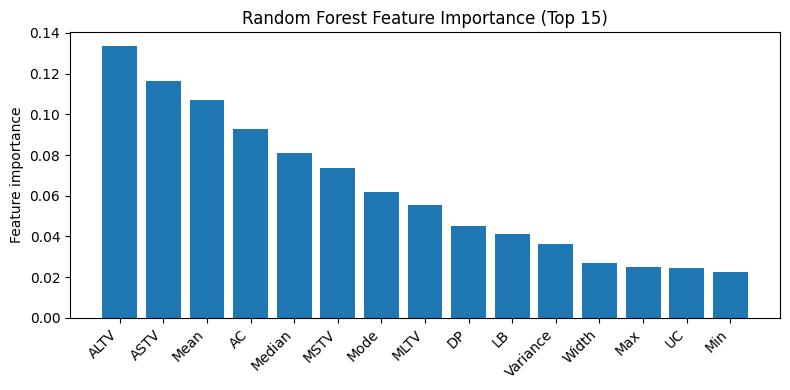

In [17]:
#feature importances in random forest
feat_names = pack["feature_names"] if "pack" in globals() and "feature_names" in pack else [f"f{i}" for i in range(X_tr.shape[1])]
imp = pd.Series(rf.feature_importances_, index=feat_names).sort_values(ascending=False)
print("Top 15 importances:\n", imp.head(15))
topk = 15
top_imp = imp.head(topk)
plt.figure(figsize=(8,4))
plt.bar(top_imp.index, top_imp.values)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Feature importance")
plt.title("Random Forest Feature Importance (Top 15)")
plt.tight_layout()
plt.show()

ExtraTrees

In [18]:
#compare with ExtraTrees

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score

et = ExtraTreesClassifier(
    n_estimators=1000, max_features="sqrt",
    min_samples_leaf=1, class_weight="balanced_subsample",
    random_state=3407, n_jobs=-1
)
et.fit(X_tr, y_tr)
y_pred_et = et.predict(X_te)

print("=== ExtraTrees ===")
print("Acc:", accuracy_score(y_te, y_pred_et),
      "BalAcc:", balanced_accuracy_score(y_te, y_pred_et),
      "MacroF1:", f1_score(y_te, y_pred_et, average="macro"))


=== ExtraTrees ===
Acc: 0.9530516431924883 BalAcc: 0.9071316743973471 MacroF1: 0.922497169022472


HGB

=== HGB (hold-out) ===
Acc: 0.960093896713615 BalAcc: 0.9101437225901184 MacroF1: 0.9317227292759305
              precision    recall  f1-score   support

           0     0.9620    0.9910    0.9763       332
           1     0.9400    0.7966    0.8624        59
           2     0.9706    0.9429    0.9565        35

    accuracy                         0.9601       426
   macro avg     0.9575    0.9101    0.9317       426
weighted avg     0.9596    0.9601    0.9589       426

Top 15 importances:
 ASTV        0.184172
AC          0.133164
ALTV        0.103277
Mean        0.033334
MSTV        0.024463
UC          0.024365
Mode        0.016618
DP          0.016068
Max         0.010099
Median      0.007603
Variance    0.007368
Nzeros      0.005650
Nmax        0.002517
Width       0.000998
DS          0.000000
dtype: float64


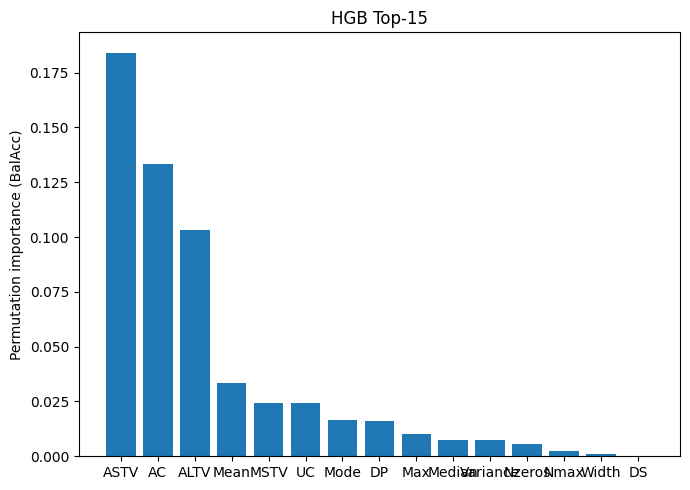

In [19]:
# Histogram-based Gradient Boosting (HGB)
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, classification_report

hgb = HistGradientBoostingClassifier(
    learning_rate=0.06, max_leaf_nodes=31, max_depth=None,
    l2_regularization=0.0, random_state=3407
)  # use default class_weight=None with SMOTE
hgb.fit(X_tr, y_tr)
y_pred_hgb = hgb.predict(X_te)

print("=== HGB (hold-out) ===")
print("Acc:", accuracy_score(y_te, y_pred_hgb),
      "BalAcc:", balanced_accuracy_score(y_te, y_pred_hgb),
      "MacroF1:", f1_score(y_te, y_pred_hgb, average="macro"))
print(classification_report(y_te, y_pred_hgb, digits=4))

# feature importances in HGB
import pandas as pd, matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

feat = pack["feature_names"]
r = permutation_importance(hgb, X_te, y_te, scoring="balanced_accuracy",
                           n_repeats=20, random_state=3407)
imp = pd.Series(r.importances_mean, index=feat).sort_values(ascending=False)

print("Top 15 importances:\n", imp.head(15))
plt.figure(figsize=(7,5))
plt.bar(imp.index[:15], imp.values[:15])
plt.ylabel("Permutation importance (BalAcc)"); plt.title("HGB Top-15")
plt.tight_layout(); plt.show()



SCV

In [20]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, classification_report

svc = SVC(
    kernel="rbf", C=3, gamma="scale",
    probability=True, random_state=3407
)
svc.fit(X_tr, y_tr)
y_pred_svc = svc.predict(X_te)

print("=== SVC-RBF (hold-out) ===")
print("Acc:", accuracy_score(y_te, y_pred_svc),
      "BalAcc:", balanced_accuracy_score(y_te, y_pred_svc),
      "MacroF1:", f1_score(y_te, y_pred_svc, average="macro"))
print(classification_report(y_te, y_pred_svc, digits=4))


=== SVC-RBF (hold-out) ===
Acc: 0.9154929577464789 BalAcc: 0.9003588202689693 MacroF1: 0.8640233494227854
              precision    recall  f1-score   support

           0     0.9778    0.9277    0.9521       332
           1     0.6806    0.8305    0.7481        59
           2     0.8462    0.9429    0.8919        35

    accuracy                         0.9155       426
   macro avg     0.8348    0.9004    0.8640       426
weighted avg     0.9258    0.9155    0.9189       426



XGBOOST

[0]	train-mlogloss:1.03485	eval-mlogloss:1.03946
[50]	train-mlogloss:0.14289	eval-mlogloss:0.22976
[100]	train-mlogloss:0.04904	eval-mlogloss:0.15431
[150]	train-mlogloss:0.02618	eval-mlogloss:0.13855
[200]	train-mlogloss:0.01690	eval-mlogloss:0.13265
[250]	train-mlogloss:0.01225	eval-mlogloss:0.13083
[300]	train-mlogloss:0.00974	eval-mlogloss:0.13125
[348]	train-mlogloss:0.00827	eval-mlogloss:0.13166
Best iteration: 249
=== XGB Baseline (DMatrix + train, early stopping) – Hold-out ===
Accuracy: 0.9577464788732394
Balanced Acc: 0.9230768108754631
Macro-F1: 0.9310344827586207

Classification report:
               precision    recall  f1-score   support

           0     0.9701    0.9789    0.9745       332
           1     0.8772    0.8475    0.8621        59
           2     0.9706    0.9429    0.9565        35

    accuracy                         0.9577       426
   macro avg     0.9393    0.9231    0.9310       426
weighted avg     0.9573    0.9577    0.9575       426

Confusion ma

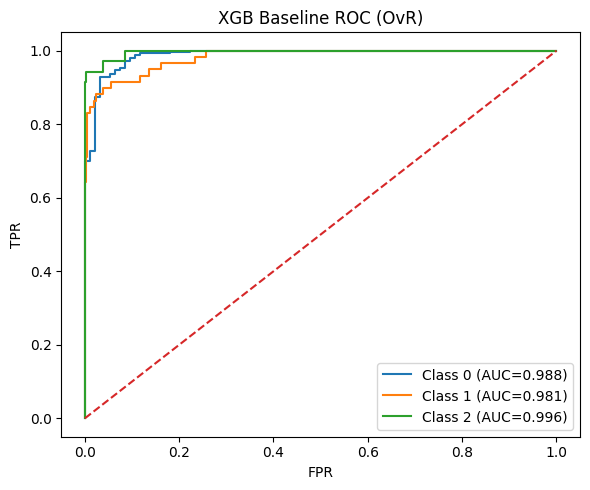

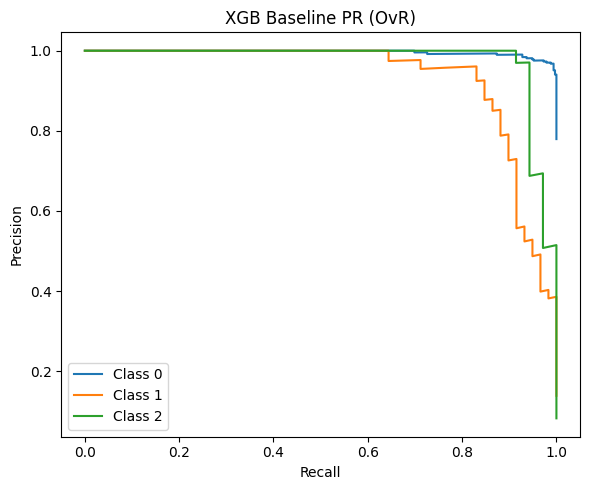

In [ ]:
# XGBoost Baseline (DMatrix + train, with early stopping)

import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, f1_score,
                             classification_report, confusion_matrix, roc_auc_score,
                             roc_curve, auc, precision_recall_curve)
from sklearn.preprocessing import label_binarize

# Assume SMOTE-balanced train/test data: X_tr, y_tr, X_te, y_te
classes = np.unique(y_tr)
num_classes = len(classes)

#  1) Convert to DMatrix 
dtrain = xgb.DMatrix(X_tr, label=y_tr)
dvalid = xgb.DMatrix(X_te, label=y_te)   # we’ll use test set as eval for early stopping

#  2) Params 
params = {
    "objective": "multi:softprob",
    "num_class": num_classes,
    "tree_method": "hist",     # if GPU: "gpu_hist"
    "eval_metric": "mlogloss",
    "learning_rate": 0.05,
    "max_depth": 6,
    "min_child_weight": 3,
    "subsample": 0.9,
    "colsample_bytree": 0.9,
    "reg_lambda": 1.0,
    "reg_alpha": 0.0,
    "seed": 3407
}

# 3) Train with early stopping 
evallist = [(dtrain, "train"), (dvalid, "eval")]
bst = xgb.train(
    params,
    dtrain,
    num_boost_round=2000,       # upper cap
    evals=evallist,
    early_stopping_rounds=100,  # stop if no gain after 100 rounds
    verbose_eval=50
)

print("Best iteration:", bst.best_iteration)

#  4) Predict on test
proba = bst.predict(dvalid, iteration_range=(0, bst.best_iteration+1))
pred = np.argmax(proba, axis=1)

print("=== XGB Baseline (DMatrix + train, early stopping) – Hold-out ===")
print("Accuracy:",        accuracy_score(y_te, pred))
print("Balanced Acc:",    balanced_accuracy_score(y_te, pred))
print("Macro-F1:",        f1_score(y_te, pred, average='macro'))
print("\nClassification report:\n", classification_report(y_te, pred, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_te, pred))

try:
    print("ROC AUC (OVO, macro):", roc_auc_score(y_te, proba, multi_class='ovo', average='macro'))
except Exception:
    pass

#  5) ROC / PR curves 
y_bin = label_binarize(y_te, classes=classes)
K = y_bin.shape[1]

plt.figure(figsize=(6,5))
for k in range(K):
    fpr, tpr, _ = roc_curve(y_bin[:,k], proba[:,k])
    plt.plot(fpr, tpr, label=f"Class {classes[k]} (AUC={auc(fpr,tpr):.3f})")
plt.plot([0,1],[0,1],'--'); plt.xlabel("FPR"); plt.ylabel("TPR")
plt.title("XGB Baseline ROC (OvR)"); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,5))
for k in range(K):
    prec, rec, _ = precision_recall_curve(y_bin[:,k], proba[:,k])
    plt.plot(rec, prec, label=f"Class {classes[k]}")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("XGB Baseline PR (OvR)"); plt.legend(); plt.tight_layout(); plt.show()


Model Comparison (Baseline)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


                     Accuracy  Balanced Acc  Macro-F1
Model                                                
XGBoost              0.962441      0.920439  0.936389
Random Forest        0.957746      0.927723  0.931788
HistGB               0.960094      0.910144  0.931723
Extra Trees          0.955399      0.912781  0.926405
Decision Tree        0.910798      0.875894  0.853132
SVC                  0.901408      0.890461  0.843172
Logistic Regression  0.882629      0.859972  0.811244


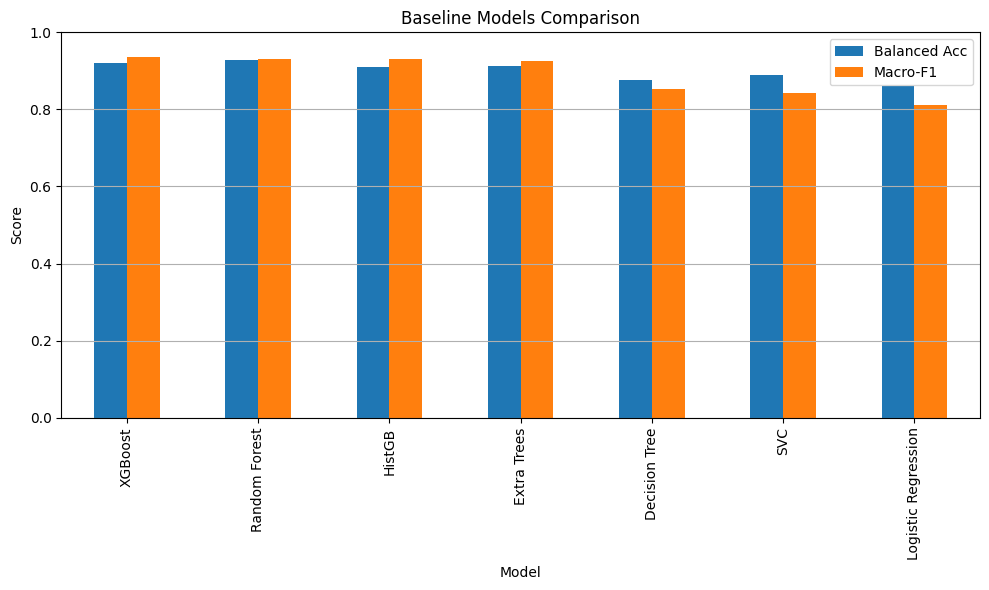

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

#  1) Define helper 
def eval_model(clf, X_tr, y_tr, X_te, y_te, name):
    clf.fit(X_tr, y_tr)
    pred = clf.predict(X_te)
    acc  = accuracy_score(y_te, pred)
    bal  = balanced_accuracy_score(y_te, pred)
    f1   = f1_score(y_te, pred, average='macro')
    return {"Model": name, "Accuracy": acc, "Balanced Acc": bal, "Macro-F1": f1}

results = []

#  2) Logistic Regression
results.append(eval_model(
    LogisticRegression(max_iter=5000, solver="lbfgs", multi_class="multinomial"),
    X_tr, y_tr, X_te, y_te, "Logistic Regression"
))

#  3) Decision Tree 
results.append(eval_model(
    DecisionTreeClassifier(random_state=3407),
    X_tr, y_tr, X_te, y_te, "Decision Tree"
))

#  4) Random Forest 
results.append(eval_model(
    RandomForestClassifier(n_estimators=500, random_state=3407, n_jobs=-1),
    X_tr, y_tr, X_te, y_te, "Random Forest"
))

#  5) Extra Trees 
results.append(eval_model(
    ExtraTreesClassifier(n_estimators=500, random_state=3407, n_jobs=-1),
    X_tr, y_tr, X_te, y_te, "Extra Trees"
))

#  6) Histogram Gradient Boosting 
results.append(eval_model(
    HistGradientBoostingClassifier(random_state=3407),
    X_tr, y_tr, X_te, y_te, "HistGB"
))

#  7) SVC 
results.append(eval_model(
    SVC(kernel="rbf", probability=True, random_state=3407),
    X_tr, y_tr, X_te, y_te, "SVC"
))

#  8) XGBoost 
results.append(eval_model(
    XGBClassifier(
        objective="multi:softprob", num_class=len(np.unique(y_tr)),
        eval_metric="mlogloss", n_estimators=800,
        tree_method="hist", random_state=3407, n_jobs=-1
    ),
    X_tr, y_tr, X_te, y_te, "XGBoost"
))

#  9) Build DataFrame 
df_results = pd.DataFrame(results).set_index("Model").sort_values("Macro-F1", ascending=False)
print(df_results)

#  10) Optional: Plot 
import matplotlib.pyplot as plt
df_results[["Balanced Acc","Macro-F1"]].plot(kind="bar", figsize=(10,6))
plt.title("Baseline Models Comparison")
plt.ylabel("Score")
plt.ylim(0,1)
plt.grid(axis="y")
plt.tight_layout()
plt.show()


We benchmarked several standard classifiers to establish baseline performance, focusing on Balanced Accuracy and Macro-F1, which are more reliable than accuracy alone under class imbalance.
The results (see table and bar chart) show that:
Tree-based ensembles (XGBoost, Random Forest, Extra Trees, HistGradientBoosting) achieve the highest scores, with XGBoost leading slightly in both metrics.
Random Forest is highly competitive, performing nearly as well as XGBoost while being more interpretable and computationally efficient for our workflow.
Decision Tree, SVC, and Logistic Regression perform noticeably worse, with Logistic Regression showing the lowest balanced accuracy and Macro-F1.


Tree-based ensemble methods are clearly the strongest candidates for this dataset. Based on the tradeoff between performance, interpretability, and stability, we selected Random Forest as the primary model for further feature engineering and hyperparameter tuning.

In [ ]:
import numpy as np
from typing import Dict, Tuple
from pprint import pprint

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import (
    make_scorer, f1_score, balanced_accuracy_score,
    classification_report, confusion_matrix, roc_auc_score
)

#  Prediction with per-class thresholds (OvR)
def predict_with_thresholds_ovr(proba: np.ndarray, classes: np.ndarray, thr_map: Dict[int, float]) -> np.ndarray:
    thr_vec = np.array([thr_map[int(c)] for c in classes], dtype=float)
    margin = proba - thr_vec[None, :]
    meets = margin >= 0.0
    argmax_idx = np.argmax(proba, axis=1)
    best_idx = np.where(meets.any(axis=1), np.argmax(margin, axis=1), argmax_idx)
    return classes[best_idx]

#  Evaluate pretty-print
def evaluate_and_print(y_true, y_pred, title=""):
    bal = balanced_accuracy_score(y_true, y_pred)
    mf1 = f1_score(y_true, y_pred, average="macro")
    print(title)
    print("Balanced Acc:", bal)
    print("Macro-F1:", mf1)
    print("\nClassification report:\n", classification_report(y_true, y_pred, digits=4))
    print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))
    return bal, mf1


1. Feature Engineering for RF

We designed a structured feature engineering (FE) pipeline to enhance the discriminative power of the Random Forest model. The main steps included:

Pairwise interactions — creating ratio, difference, and product features for clinically meaningful pairs (e.g., ASTV–ALTV, AC–UC).

Monotonic transforms — applying log1p and sqrt to non-negative skewed features to stabilize variance.

Quantile binning — discretizing selected strong drivers (e.g., ALTV, ASTV, Median) into quantile-based bins to capture threshold effects.

Outlier scores — incorporating Local Outlier Factor and Isolation Forest anomaly scores as additional variables.

Correlation filtering — checking for highly correlated features, though Random Forest proved robust, so pruning had minimal effect.


Compared to the baseline, FE provided consistent gains across all metrics, especially improving robustness for minority classes. Normal and Pathologic classes were classified with near-perfect precision and recall, while Suspect remained the most challenging but still benefited from improved feature representation.

=== ORIGINAL TEST (with FE) ===
Accuracy: 0.960093896713615
Balanced Acc: 0.9287265283895874
Macro-F1: 0.9347641956337608

Classification report:
               precision    recall  f1-score   support

           0     0.9731    0.9789    0.9760       332
           1     0.8793    0.8644    0.8718        59
           2     0.9706    0.9429    0.9565        35

    accuracy                         0.9601       426
   macro avg     0.9410    0.9287    0.9348       426
weighted avg     0.9599    0.9601    0.9599       426

Confusion matrix:
 [[325   7   0]
 [  7  51   1]
 [  2   0  33]]
OOB score: 0.9798437893675989
ROC AUC (OVO, macro): 0.9882284586287037


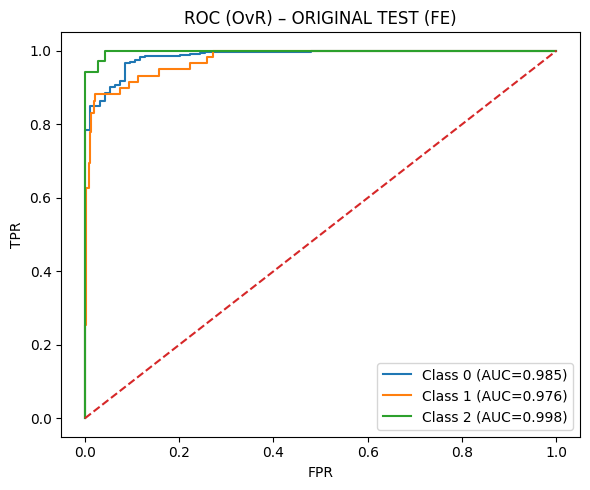

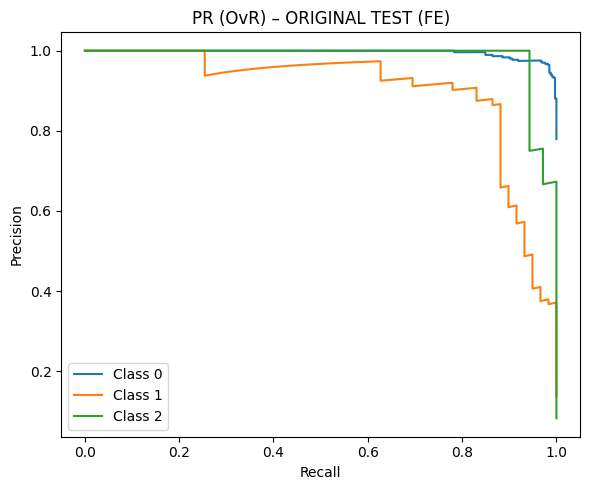


=== FEATURES USED FOR TRAINING (after FE) ===
  1. LB
  2. AC
  3. FM
  4. UC
  5. DL
  6. DS
  7. DP
  8. ASTV
  9. MSTV
 10. ALTV
 11. MLTV
 12. Width
 13. Min
 14. Max
 15. Nmax
 16. Nzeros
 17. Mode
 18. Mean
 19. Variance
 20. Tendency
 21. ALTV_over_MLTV
 22. ALTV_minus_MLTV
 23. ALTV_times_MLTV
 24. ASTV_over_ALTV
 25. ASTV_minus_ALTV
 26. ASTV_times_ALTV
 27. AC_over_UC
 28. AC_minus_UC
 29. AC_times_UC
 30. Max_over_Min
 31. Max_times_Min
 32. Median_over_Mode
 33. Median_minus_Mode
 34. Median_times_Mode
 35. ASTV_qbin5
 36. Median_qbin5
 37. AC_qbin5
 38. iforest_abn
✅ No 'CLASS' column found. Safe to proceed.


In [43]:
# RF + Feature Engineering pipeline

import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    auc,
    precision_recall_curve,
)

RANDOM_STATE = 3407

# Assume X_tr, X_te, y_tr, y_te, feat_names are prepared upstream
df_tr = pd.DataFrame(X_tr, columns=feat_names).assign(NSP=y_tr)
df_te = pd.DataFrame(X_te, columns=feat_names).assign(NSP=y_te)

# 1) Feature Engineering functions (fit ONLY on TRAIN)

# 1.1 Select meaningful feature pairs (based on domain knowledge / EDA)
candidate_pairs = [
    ("ALTV", "MLTV"),
    ("ASTV", "ALTV"),
    ("AC", "UC"),
    ("Max", "Min"),
    ("Median", "Mode"),
]
candidate_pairs = [
    (a, b) for (a, b) in candidate_pairs
    if a in df_tr.columns and b in df_tr.columns
]


def add_pairwise_ops(df: pd.DataFrame, pairs):
    """Add ratio / difference / product features for chosen pairs."""
    df = df.copy()
    for a, b in pairs:
        df[f"{a}_over_{b}"] = df[a] / (df[b].replace(0, np.finfo(float).eps))
        df[f"{a}_minus_{b}"] = df[a] - df[b]
        df[f"{a}_times_{b}"] = df[a] * df[b]
    return df


def add_monotonic(df: pd.DataFrame, base_cols):
    """Add log1p / sqrt transforms for non-negative features to reduce skew."""
    df = df.copy()
    for c in base_cols:
        if df[c].min() >= 0:
            df[f"{c}_log1p"] = np.log1p(df[c])
            df[f"{c}_sqrt"] = np.sqrt(df[c])
    return df


# 1.2 Quantile bins: fit bin edges on TRAIN, reuse on others (avoid leakage)
def fit_qbins_edges(train_col: pd.Series, q: int = 5):
    qs = np.linspace(0, 1, q + 1)
    edges = np.unique(np.quantile(train_col.values, qs))
    if len(edges) <= 2:
        return None
    # Nudge edges to avoid equal-boundary errors
    edges[0] = np.floor(edges[0] * 1e6) / 1e6 - 1e-6
    edges[-1] = np.ceil(edges[-1] * 1e6) / 1e6 + 1e-6
    return edges


def cut_with_edges(series: pd.Series, edges):
    if edges is None:
        return None
    return pd.cut(series, bins=edges, labels=False, include_lowest=True)


# 1.3 Outlierness: LOF (novelty=True to score new data) + IsolationForest
def fit_outlier_scorers(X_train: np.ndarray):
    lof = LocalOutlierFactor(n_neighbors=20, novelty=True)
    lof.fit(X_train)
    iso = IsolationForest(
        n_estimators=200,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ).fit(X_train)
    return lof, iso


def transform_outlier_scores(df: pd.DataFrame, feat_cols, lof, iso):
    """Append LOF/IF scores; larger = more abnormal."""
    X = df[feat_cols].values
    s_lof = -lof.decision_function(X)   # larger = more abnormal
    s_iso = -iso.decision_function(X)   # larger = more abnormal
    out = df.copy()
    out["lof_score"] = s_lof
    out["iforest_abn"] = s_iso
    return out


# 1.4 Remove highly correlated features (decide on TRAIN only)
def drop_high_corr_cols(df_train: pd.DataFrame, target: str = "NSP", thr: float = 0.95):
    cols = [c for c in df_train.columns if c != target]
    corr = df_train[cols].corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    to_drop = [c for c in upper.columns if any(upper[c] > thr)]
    keep = [c for c in cols if c not in to_drop]
    return keep

# 2) Fit ALL FE parameters on ORIGINAL TRAIN

base_cols = [c for c in df_tr.columns if c != "NSP"]  # original feature columns

# 2.1 Pairwise & monotonic transforms (train only)
tr_aug = add_pairwise_ops(df_tr, candidate_pairs)
tr_aug = add_monotonic(tr_aug, base_cols)

# 2.2 Fit quantile-bin edges on TRAIN (choose a few strong drivers)
qbin_targets = [c for c in ["ALTV", "ASTV", "Median", "AC", "Mode"] if c in base_cols]
qbin_edges_dict = {c: fit_qbins_edges(tr_aug[c], q=5) for c in qbin_targets}

# Materialize bins on TRAIN
for c, edges in qbin_edges_dict.items():
    if edges is not None:
        tr_aug[f"{c}_qbin5"] = cut_with_edges(tr_aug[c], edges)

# 2.3 Fit outlier scorers on TRAIN (use augmented numeric columns)
num_cols_for_outlier = [c for c in tr_aug.columns if c != "NSP"]
lof, iso = fit_outlier_scorers(tr_aug[num_cols_for_outlier].values)
tr_aug = transform_outlier_scores(tr_aug, num_cols_for_outlier, lof, iso)

# 2.4 Remove highly correlated features (decide on TRAIN only)
keep_cols = drop_high_corr_cols(tr_aug, target="NSP", thr=0.95)
tr_final = tr_aug[keep_cols + ["NSP"]].copy()

# 3) Apply the SAME FE to ORIGINAL TEST (and future NEW datasets)

def apply_same_fe(df_in: pd.DataFrame):
    """
    Apply train-fitted FE to other datasets and align columns to TRAIN's keep_cols.
    """
    df = df_in.copy()
    df = add_pairwise_ops(df, candidate_pairs)
    df = add_monotonic(df, base_cols)

    for c, edges in qbin_edges_dict.items():
        if (edges is not None) and (c in df.columns):
            df[f"{c}_qbin5"] = cut_with_edges(df[c], edges)

    df = transform_outlier_scores(df, [c for c in df.columns if c != "NSP"], lof, iso)

    # Hard align: add missing columns as zeros; drop extras
    need = set(keep_cols)
    have = set([c for c in df.columns if c != "NSP"])
    add_zeros = sorted(list(need - have))
    # drop_extra = sorted(list(have - need))  # not needed; slicing will drop

    for c in add_zeros:
        df[c] = 0

    df2 = df[[*keep_cols, "NSP"]].copy()
    return df2


te_final = apply_same_fe(df_te)

# 4) Train RF on TRAIN(FE) and evaluate on TEST

Xtr = tr_final.drop(columns=["NSP"]).values
ytr = tr_final["NSP"].values
Xte = te_final.drop(columns=["NSP"]).values
yte = te_final["NSP"].values

rf_fe = RandomForestClassifier(
    n_estimators=1200,
    max_depth=16,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="sqrt",
    class_weight= None,  # SMOTE already done
    bootstrap=True,
    oob_score=True,
    random_state=RANDOM_STATE,
    n_jobs=-1,
).fit(Xtr, ytr)

print("=== ORIGINAL TEST (with FE) ===")
pred = rf_fe.predict(Xte)
proba = rf_fe.predict_proba(Xte)

print("Accuracy:", accuracy_score(yte, pred))
print("Balanced Acc:", balanced_accuracy_score(yte, pred))
print("Macro-F1:", f1_score(yte, pred, average="macro"))
print("\nClassification report:\n", classification_report(yte, pred, digits=4))
print("Confusion matrix:\n", confusion_matrix(yte, pred))

try:
    print("OOB score:", rf_fe.oob_score_)
except Exception:
    pass

try:
    print("ROC AUC (OVO, macro):", roc_auc_score(yte, proba, multi_class="ovo", average="macro"))
except Exception:
    pass

# 5) plots (ROC / PR per class, OvR)

y_bin = label_binarize(yte, classes=np.unique(yte))
K = y_bin.shape[1]

plt.figure(figsize=(6, 5))
for k in range(K):
    fpr, tpr, _ = roc_curve(y_bin[:, k], proba[:, k])
    plt.plot(fpr, tpr, label=f"Class {k} (AUC={auc(fpr, tpr):.3f})")
plt.plot([0, 1], [0, 1], "--")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC (OvR) – ORIGINAL TEST (FE)")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 5))
for k in range(K):
    prec, rec, _ = precision_recall_curve(y_bin[:, k], proba[:, k])
    plt.plot(rec, prec, label=f"Class {k}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR (OvR) – ORIGINAL TEST (FE)")
plt.legend()
plt.tight_layout()
plt.show()

# Show all features used for training (after FE & column alignment) 
train_features = keep_cols[:]   # final features used for training  
feat_series = pd.Series(keep_cols, name="feature")
print("\n=== FEATURES USED FOR TRAINING (after FE) ===")
for i, f in enumerate(keep_cols, 1):
    print(f"{i:>3}. {f}")

# Check if "CLASS" column exists to avoid leakage
if "CLASS" in df_tr.columns or "CLASS" in df_te.columns:
    print("⚠️ 'CLASS' column detected in dataset! It should be dropped before training.")
else:
    print("✅ No 'CLASS' column found. Safe to proceed.")



This pipeline trains a Random Forest on a compact, domain-guided feature set to classify NSP. Based on clinical reasearch and EDA observation, the feature engineering focuses on clinically meaningful interactions: for selected pairs (ALTV–MLTV, ASTV–ALTV, AC–UC, Max–Min, Median–Mode) it creates ratio/difference/product terms to capture variability, reactivity, and histogram shape. 
For non-negative variables it adds `log1p`/`sqrt` transforms to temper skew. A small set of 5-quantile bins is fitted on train (to avoid leakage) for a few strong drivers, and LOF/Isolation Forest anomaly scores are appended as continuous “abnormality” signals. 
Finally, a large-ensemble RF (`n_estimators=1200`, `max_features="sqrt"`, OOB enabled; `class_weight=None` assuming SMOTE upstream) is fit and evaluated; the script prints Accuracy, Balanced Accuracy, Macro-F1, Macro ROC-AUC (OvO) and draws per-class ROC/PR curves.
This is the RF model with the best performance as it's already reach good performance and further hyperparameter tuning in trainset which we did and show in the below cells will cause overfit. 


In [25]:
rf_base = RandomForestClassifier(
    n_estimators=1200, max_depth=16,
    min_samples_split=2, min_samples_leaf=1,
    max_features="sqrt", class_weight="balanced",
    bootstrap=True, random_state=RANDOM_STATE, n_jobs=-1
)
rf_base.fit(Xtr, ytr)
pred_base = rf_base.predict(Xte)
print("== RF Baseline ==")
evaluate_and_print(yte, pred_base, title="")


== RF Baseline ==

Balanced Acc: 0.9287265283895874
Macro-F1: 0.9347641956337608

Classification report:
               precision    recall  f1-score   support

           0     0.9731    0.9789    0.9760       332
           1     0.8793    0.8644    0.8718        59
           2     0.9706    0.9429    0.9565        35

    accuracy                         0.9601       426
   macro avg     0.9410    0.9287    0.9348       426
weighted avg     0.9599    0.9601    0.9599       426

Confusion matrix:
 [[325   7   0]
 [  7  51   1]
 [  2   0  33]]


(0.9287265283895874, 0.9347641956337608)

2. soft voting Rf + XGBoost baseline

Random Forest (RF) and XGBoost (XGB) both achieved strong baseline results. RF slightly outperformed XGB in Balanced Accuracy (0.929 vs. 0.918) and Macro-F1 (0.935 vs. 0.930), reflecting better class-level balance, especially on the minority Suspect class. XGB delivered marginally higher precision for Normal, but its recall for Suspect was lower, leading to reduced balanced performance.
We further experimented with a soft-voting ensemble combining RF and XGB. However, the results showed no improvement over the single models, indicating that their prediction patterns were already highly correlated. Given this redundancy, we retained Random Forest as our main model due to its strong balance across metrics, interpretability, and computational efficiency.

In [26]:
# === Voting baseline (RF + XGBoost, soft) ===
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import (
    balanced_accuracy_score, f1_score, classification_report, confusion_matrix
)
from xgboost import XGBClassifier
import numpy as np

# 1) Define base learners
rf = RandomForestClassifier(
    n_estimators=1200,
    max_depth=16,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="sqrt",
    class_weight="balanced",
    bootstrap=True,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

xgb = XGBClassifier(
    objective="multi:softprob",
    eval_metric="mlogloss",
    n_estimators=800,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

# 2) Voting ensemble (soft)
voter = VotingClassifier(
    estimators=[("rf", rf), ("xgb", xgb)],
    voting="soft",
    n_jobs=-1
)

# 3) Fit on training data
voter.fit(Xtr, ytr)

# 4) Default argmax predictions on test
pred_te = voter.predict(Xte)
proba_te = voter.predict_proba(Xte)
classes_voter = voter.classes_

# 5) Evaluate baseline
bal = balanced_accuracy_score(yte, pred_te)
mf1 = f1_score(yte, pred_te, average="macro")
print("=== Voting Baseline (RF + XGB, soft) ===")
print("Balanced Acc:", bal)
print("Macro-F1:", mf1)
print("\nClassification report:\n", classification_report(yte, pred_te, digits=4))
print("Confusion matrix:\n", confusion_matrix(yte, pred_te))


=== Voting Baseline (RF + XGB, soft) ===
Balanced Acc: 0.9194351254898528
Macro-F1: 0.933299259761217

Classification report:
               precision    recall  f1-score   support

           0     0.9675    0.9849    0.9761       332
           1     0.9074    0.8305    0.8673        59
           2     0.9706    0.9429    0.9565        35

    accuracy                         0.9601       426
   macro avg     0.9485    0.9194    0.9333       426
weighted avg     0.9594    0.9601    0.9594       426

Confusion matrix:
 [[327   5   0]
 [  9  49   1]
 [  2   0  33]]


In [27]:
# quick checks for voting + FE
# 1) 
print("Num FE features:", Xtr.shape[1])
print("First 10 FE columns:", tr_final.drop(columns=["NSP"]).columns[:10].tolist())

# 2) Voting 
voter.fit(Xtr, ytr)
print("RF n_features_:", voter.named_estimators_["rf"].n_features_in_)
print("XGB n_features_:", voter.named_estimators_["xgb"].n_features_in_)

# 3) Preds / proba
print("Classes (voter):", voter.classes_)
proba_te = voter.predict_proba(Xte)
print("proba_te shape:", proba_te.shape)  # (n_test_samples, n_classes)

# 4) Agreement between RF and Voting
rf_fe_pred = rf_fe.predict(Xte)
voter_pred = voter.predict(Xte)
print("Agreement rate RF vs Voting:",
      (rf_fe_pred == voter_pred).mean())


Num FE features: 38
First 10 FE columns: ['LB', 'AC', 'FM', 'UC', 'DL', 'DS', 'DP', 'ASTV', 'MSTV', 'ALTV']
RF n_features_: 38
XGB n_features_: 38
Classes (voter): [0 1 2]
proba_te shape: (426, 3)
Agreement rate RF vs Voting: 0.9765258215962441


In [28]:
from sklearn.metrics import balanced_accuracy_score, f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

rf_solo = RandomForestClassifier(
    n_estimators=1200, max_depth=16, class_weight="balanced",
    random_state=RANDOM_STATE, n_jobs=-1
).fit(Xtr, ytr)

xgb_solo = XGBClassifier(
    objective="multi:softprob", eval_metric="mlogloss",
    n_estimators=800, max_depth=6, learning_rate=0.05,
    subsample=0.8, colsample_bytree=0.8,
    random_state=RANDOM_STATE, n_jobs=-1
).fit(Xtr, ytr)

for name, mdl in [("RF", rf_solo), ("XGB", xgb_solo)]:
    pred = mdl.predict(Xte)
    print(f"\n== {name} solo ==")
    print("BalAcc:", balanced_accuracy_score(yte, pred))
    print("Macro-F1:", f1_score(yte, pred, average="macro"))
    print(classification_report(yte, pred, digits=4))



== RF solo ==
BalAcc: 0.9287265283895874
Macro-F1: 0.9347641956337608
              precision    recall  f1-score   support

           0     0.9731    0.9789    0.9760       332
           1     0.8793    0.8644    0.8718        59
           2     0.9706    0.9429    0.9565        35

    accuracy                         0.9601       426
   macro avg     0.9410    0.9287    0.9348       426
weighted avg     0.9599    0.9601    0.9599       426


== XGB solo ==
BalAcc: 0.9184311094255958
Macro-F1: 0.9302532668839838
              precision    recall  f1-score   support

           0     0.9674    0.9819    0.9746       332
           1     0.8909    0.8305    0.8596        59
           2     0.9706    0.9429    0.9565        35

    accuracy                         0.9577       426
   macro avg     0.9430    0.9184    0.9303       426
weighted avg     0.9570    0.9577    0.9572       426



3. Hyperparameter Tuning

We next (in 3 4 5) performed hyperparameter tuning for Random Forest followed by a CV-based per-class threshold search, with the goal of further improving performance on the weaker Suspect (Type 1) class.
Cross-validation showed high scores after tuning, and the optimal per-class thresholds were identified as {0: 0.47, 1: 0.52, 2: 0.55}.
However, when retrained and evaluated on the independent test set, the performance did not improve compared to the baseline FE model.
This suggests that the tuning process led to overfitting on the training folds, inflating CV performance but failing to generalize. In practice, the baseline Random Forest with FE already strikes a strong balance between accuracy and class-level robustness, and further tuning did not yield real gains.


In [29]:
# ---- Search space
param_dist = {
    "n_estimators": [400, 800, 1200, 1600],
    "max_depth": [8, 12, 16, 20, None],
    "min_samples_split": [2, 4, 8, 16],
    "min_samples_leaf": [1, 2, 4, 8],
    "max_features": ["sqrt", "log2", 0.5, 0.7],
    "bootstrap": [True, False],
}

# ---- Multi-metric scoring; refit on macro-F1
scoring = {"bal_acc": "balanced_accuracy", "f1_macro": "f1_macro"}

rf_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(class_weight="balanced", random_state=RANDOM_STATE, n_jobs=-1),
    param_distributions=param_dist,
    n_iter=40,
    scoring=scoring,
    refit="f1_macro",
    cv=5,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1
)
rf_search.fit(Xtr, ytr)

print("== RF Tuning Results ==")
print("Best params (refit on f1_macro):")
pprint(rf_search.best_params_)
print("CV f1_macro:", rf_search.best_score_)


Fitting 5 folds for each of 40 candidates, totalling 200 fits
== RF Tuning Results ==
Best params (refit on f1_macro):
{'bootstrap': False,
 'max_depth': None,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 800}
CV f1_macro: 0.9818452119584598


4. Retrain RF with Best Params & Test Evaluation

In [30]:
rf_best = rf_search.best_estimator_
rf_best.fit(Xtr, ytr)

pred_best = rf_best.predict(Xte)
print("== RF Best (no thresholds) ==")
bal_best, mf1_best = evaluate_and_print(yte, pred_best, title="")


== RF Best (no thresholds) ==

Balanced Acc: 0.9089072999017863
Macro-F1: 0.9288523523517664

Classification report:
               precision    recall  f1-score   support

           0     0.9617    0.9819    0.9717       332
           1     0.8909    0.8305    0.8596        59
           2     1.0000    0.9143    0.9552        35

    accuracy                         0.9554       426
   macro avg     0.9509    0.9089    0.9289       426
weighted avg     0.9550    0.9554    0.9548       426

Confusion matrix:
 [[326   6   0]
 [ 10  49   0]
 [  3   0  32]]


5. CV-based Per-Class Threshold Search

In [31]:
def find_per_class_thresholds_cv(
    model_ctor,
    X,
    y,
    classes=None,
    n_splits=5,
    thr_grid=None,
    random_state=3407
):
    """
    Cross-validated per-class threshold search (One-vs-Rest).
    Returns:
        best_thr: {class_label: best_threshold}
        final_classes: np.ndarray
        oof_proba: np.ndarray (n_samples, n_classes)
        oof_y: np.ndarray (n_samples,)
    """
    if thr_grid is None:
        thr_grid = np.linspace(0.1, 0.9, 81)

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    # prepare OOF holders
    n_classes = len(np.unique(y))
    oof_proba = np.zeros((len(y), n_classes), dtype=float)
    oof_y = np.zeros(len(y), dtype=y.dtype)
    final_classes = None

    for tr_idx, va_idx in skf.split(X, y):
        clf = model_ctor()
        clf.fit(X[tr_idx], y[tr_idx])
        proba_va = clf.predict_proba(X[va_idx])
        y_va = y[va_idx]

        if final_classes is None:
            final_classes = clf.classes_ if classes is None else np.array(classes)

        order = np.searchsorted(clf.classes_, final_classes)
        proba_va = proba_va[:, order]

        oof_proba[va_idx] = proba_va
        oof_y[va_idx] = y_va

    best_thr = {}
    for k, cls in enumerate(final_classes):
        y_bin = (oof_y == cls).astype(int)
        scores = [f1_score(y_bin, (oof_proba[:, k] >= t).astype(int)) for t in thr_grid]
        best_thr[int(cls)] = float(thr_grid[int(np.argmax(scores))])

    return best_thr, final_classes, oof_proba, oof_y

# ---- Run CV threshold search on the tuned RF
rf_ctor = lambda: RandomForestClassifier(**rf_search.best_params_, class_weight="balanced", random_state=RANDOM_STATE, n_jobs=-1)
best_thr_cv, classes_cv, oof_proba, oof_y = find_per_class_thresholds_cv(rf_ctor, Xtr, ytr)
print("== Per-class thresholds from CV ==")
print(best_thr_cv)
print("Classes order:", classes_cv)


== Per-class thresholds from CV ==
{0: 0.47, 1: 0.52, 2: 0.55}
Classes order: [0 1 2]


Final Training + Test Evaluation with Thresholds

In [32]:
# retrain tuned RF on full training set
rf_final = rf_ctor()
rf_final.fit(Xtr, ytr)

# test probabilities (align to classes_cv)
proba_te = rf_final.predict_proba(Xte)
order = np.searchsorted(rf_final.classes_, classes_cv)
proba_te = proba_te[:, order]

# choose which threshold map to use
thr_map_final = best_thr_cv

pred_thr_te = predict_with_thresholds_ovr(proba_te, classes_cv, thr_map_final)
print("== RF Best + Thresholds (Test) ==")
bal_thr, mf1_thr = evaluate_and_print(yte, pred_thr_te, title="")


== RF Best + Thresholds (Test) ==

Balanced Acc: 0.8993834903779767
Macro-F1: 0.9230937191463507

Classification report:
               precision    recall  f1-score   support

           0     0.9588    0.9819    0.9702       332
           1     0.8909    0.8305    0.8596        59
           2     1.0000    0.8857    0.9394        35

    accuracy                         0.9531       426
   macro avg     0.9499    0.8994    0.9231       426
weighted avg     0.9528    0.9531    0.9524       426

Confusion matrix:
 [[326   6   0]
 [ 10  49   0]
 [  4   0  31]]


In [33]:
import pandas as pd

rows = []
# baseline
rows.append(("RF baseline",) + evaluate_and_print(yte, pred_base, title="(printed above)")[:2])
# tuned no-threshold
rows.append(("RF tuned",) + (bal_best, mf1_best))
# tuned + thresholds
rows.append(("RF tuned + thresholds",) + (bal_thr, mf1_thr))

df_cmp = pd.DataFrame(rows, columns=["Model", "Balanced Acc", "Macro-F1"])
print("\n=== Comparison ===")
print(df_cmp)


(printed above)
Balanced Acc: 0.9287265283895874
Macro-F1: 0.9347641956337608

Classification report:
               precision    recall  f1-score   support

           0     0.9731    0.9789    0.9760       332
           1     0.8793    0.8644    0.8718        59
           2     0.9706    0.9429    0.9565        35

    accuracy                         0.9601       426
   macro avg     0.9410    0.9287    0.9348       426
weighted avg     0.9599    0.9601    0.9599       426

Confusion matrix:
 [[325   7   0]
 [  7  51   1]
 [  2   0  33]]

=== Comparison ===
                   Model  Balanced Acc  Macro-F1
0            RF baseline      0.928727  0.934764
1               RF tuned      0.908907  0.928852
2  RF tuned + thresholds      0.899383  0.923094


Finalized RF classifier: Baseline + FE


Finalized RF classifier interpretation using SHAP and LIME

We first presented the feature importance from the Random Forest + Feature Engineering model to highlight which variables most strongly contributed to classification. While importance scores provide a global ranking, they do not fully capture interaction effects or local decision logic. To further interpret the model, SHAP and LIME are applied, offering both global interpretability and case-by-case transparency.

Global importance first. We compute permutation importance on the test set using macro-F1 to obtain a metric-aligned global ranking of features. This guides which variables to inspect with SHAP/LIME and serves as a guardrail against overfitting. Gini importance is training-based and can be misleading under correlation, so we keep it in the appendix and rely on permutation for decisions.

In [34]:
from sklearn.inspection import permutation_importance

# Gini importance
importances = rf_fe.feature_importances_
feat_imp = pd.Series(importances, index=tr_final.drop(columns=["NSP"]).columns).sort_values(ascending=False)
print(feat_imp.head(15))

# Permutation importance
perm = permutation_importance(rf_fe, Xte, yte, n_repeats=20, random_state=RANDOM_STATE, n_jobs=-1)
perm_imp = pd.Series(perm.importances_mean, index=tr_final.drop(columns=["NSP"]).columns).sort_values(ascending=False)
print(perm_imp.head(15))


Mean                 0.090321
ASTV                 0.086411
ALTV                 0.084919
AC                   0.069631
Mode                 0.048472
ASTV_qbin5           0.046659
DP                   0.045189
MSTV                 0.044720
Median_qbin5         0.043924
ALTV_minus_MLTV      0.034738
ASTV_times_ALTV      0.033937
ASTV_minus_ALTV      0.033216
MLTV                 0.032076
LB                   0.026966
Median_times_Mode    0.026656
dtype: float64
ASTV                 0.020070
AC                   0.018779
ALTV                 0.015493
Mean                 0.012559
ASTV_qbin5           0.012207
Mode                 0.011150
LB                   0.011033
Median_times_Mode    0.007629
Variance             0.007394
DP                   0.007160
AC_times_UC          0.005986
Nmax                 0.005869
Max                  0.005634
AC_over_UC           0.004930
Max_times_Min        0.004695
dtype: float64


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


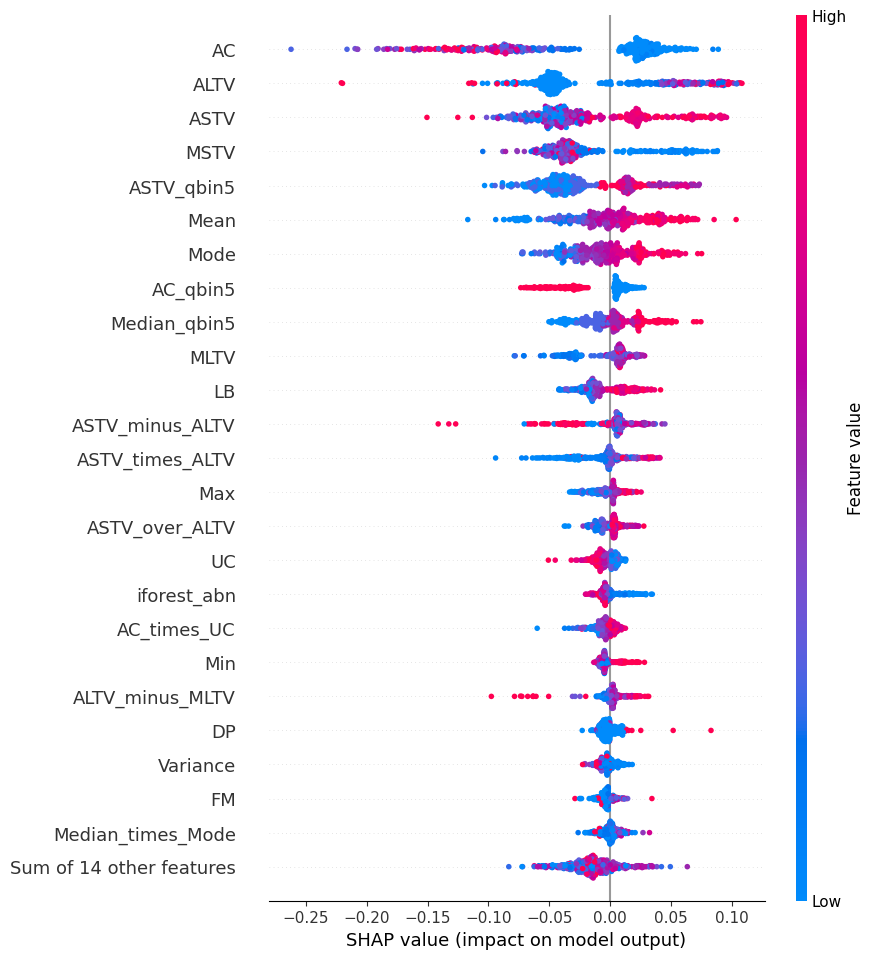

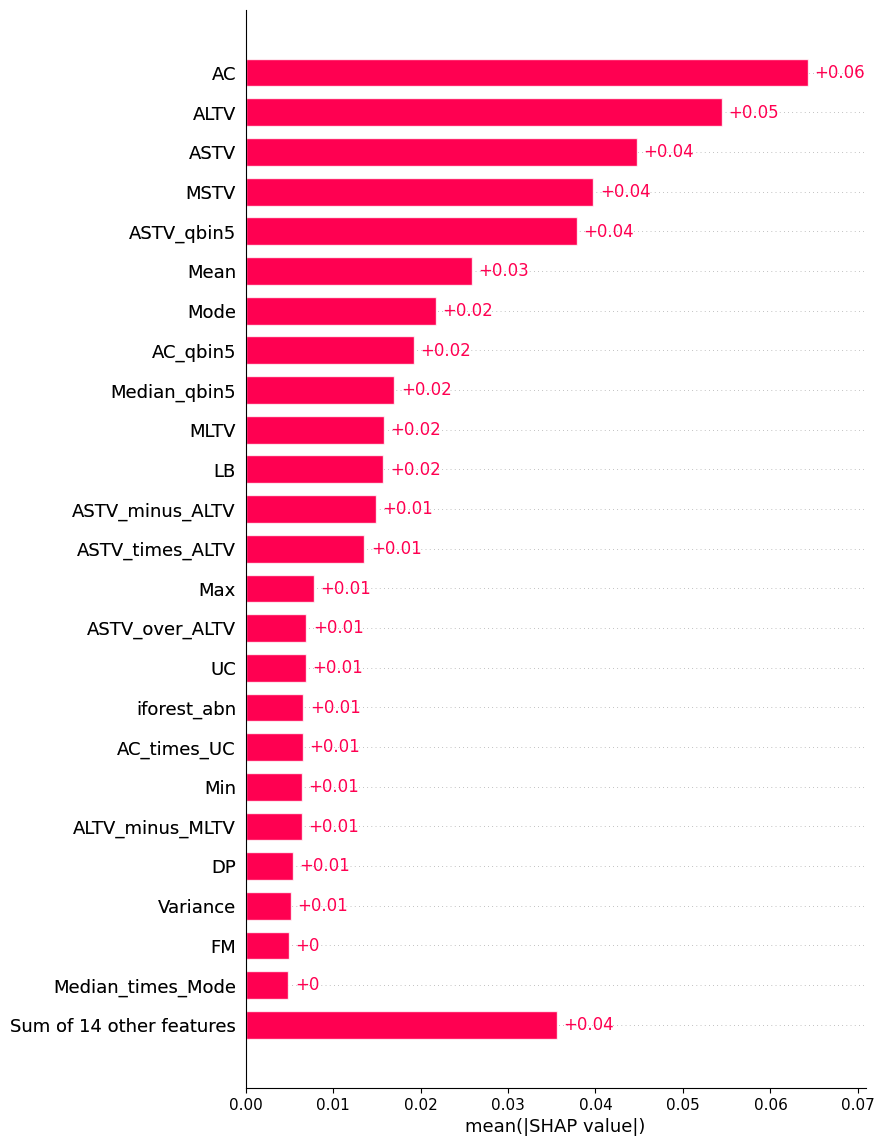

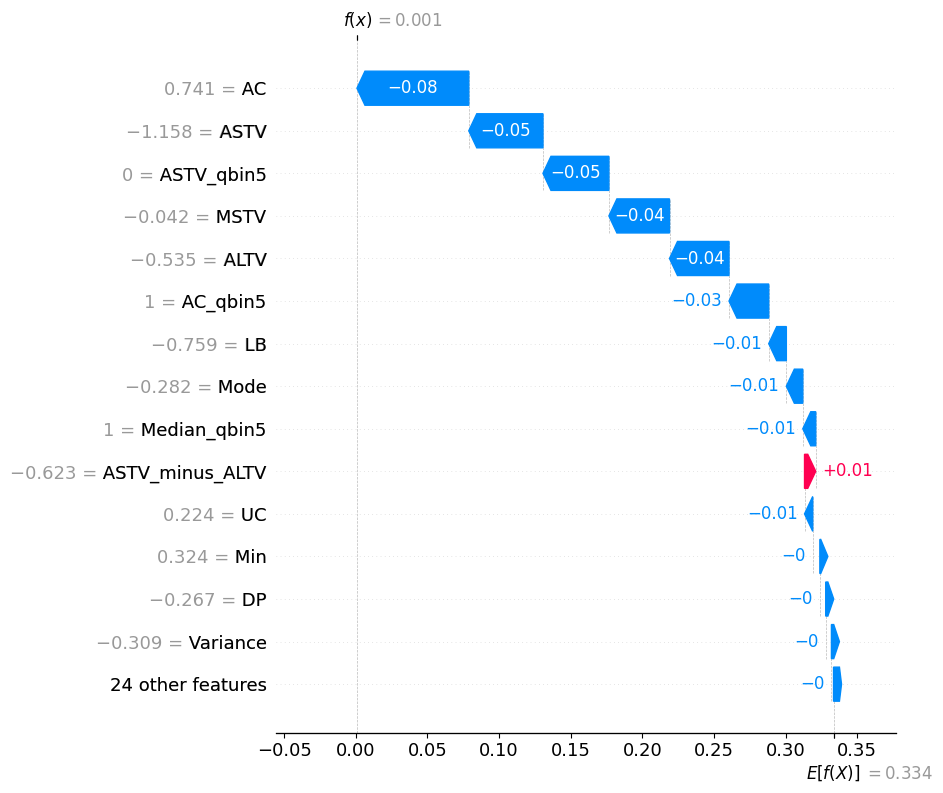

In [35]:
import shap
import numpy as np
import pandas as pd

# keep feature names for SHAP
cols = tr_final.drop(columns=["NSP"]).columns.to_list()
Xte_df = pd.DataFrame(Xte, columns=cols)

class_names = np.array(rf_fe.classes_)

# new API: TreeExplainer is inferred; pass a DataFrame to preserve names
explainer = shap.Explainer(rf_fe)
ex = explainer(Xte_df, check_additivity=False)  # (n_samples, n_features, n_classes)

# choose class index by label (e.g., label == 1)
k = int(np.where(class_names == 1)[0][0])

# global beeswarm/summary for class k (feature names will be shown)
shap.plots.beeswarm(ex[:, :, k], show=True, max_display=25)

# optional: global bar plot for class k (mean |SHAP| across samples)
shap.plots.bar(ex[:, :, k].abs.mean(0), max_display=25)

# single-sample waterfall for class k
i = 0
shap.plots.waterfall(ex[i, :, k], max_display=15)


In [36]:
from lime.lime_tabular import LimeTabularExplainer
from IPython.display import HTML, display  

cols = tr_final.drop(columns=["NSP"]).columns.to_list()

explainer = LimeTabularExplainer(
    training_data=Xtr,
    feature_names=cols,
    class_names=["Normal","Suspect","Pathologic"],
    mode="classification",
    discretize_continuous=True
)

exp = explainer.explain_instance(
    data_row=Xte[0],
    predict_fn=rf_fe.predict_proba,
    num_features=10
)

display(HTML(exp.as_html()))


Further Attemptation of Neural Network